Read raw events from our feather files:

In [467]:
import pandas as pd
from ruamel.yaml import YAML

yaml = YAML(typ="safe")

with open("cfg.yaml") as f:
    config = yaml.load(f)

In [468]:
from itertools import chain

def load_data():
    dataframes = []
    for parent, dirs, files in chain(
        os.walk("data/id-type-created_at-repo.name-repo.url-actor.id-actor.login/"),
        os.walk("data/old"),
        os.walk("data/email"),

    ):
        for fname in files:
            if fname.endswith(".feather"):
                path = os.path.join(parent, fname)
                dataframes.append(pd.read_feather(path))
    return pd.concat(dataframes)


raw_data = load_data()

Clean the data a bit:

Data in some older years has a different schema:

- repo_name is just `nbviewer` not `jupyter/nbviewer`
- only `repo_url` contains full org/name
- `repo_url` may be either `https://github.com/jupyter/nbviewer` or `https://api.github.com/repos/jupyter/nbviewer`
- older events may not have actor.id or event.id
- actor.id is float, despite being integer data
- event.id is str, despite being integer data
- some events appear to be double-reported

So:

- drop some duplicate events
- drop id field after removing duplicates
- make repo_name consistent across schema changes
- add org column from the first part of the repo_name
- sort by date
- backfill missing actor_id
- fill still-missing actor_id with new unique values
- ignore bot-initiated events
- ignore fork/watch events

In [492]:
# some events may be reported multiple times in the data
raw_rows = len(raw_data)
df = raw_data.drop_duplicates()  # just on "id"? "id" is undefined for old data
without_dupes = len(df)
print(f"Dropped {len(raw_data) - len(df)}/{len(raw_data)} duplicate events")
# drop uninteresting event-id columnt after removing duplicates
df = df.drop(columns=["id"])

# drop bot events
known_bots = [
    "travisbot",
    "sourcegraphbot",
    "jupyterlab-bot",
    "npmcdn-to-unpkg-bot",
    "codetriage-readme-bot",
    "henchbot",
    "lektor-bot",
]
df = df[~(df.actor_login.str.endswith("[bot]") | df.actor_login.isin(known_bots))]
without_bots = len(df)

print(f"Dropped {without_dupes - without_bots} bot events")

# parse non-uniform repo.url into repo_name, repo_url
df["repo_name"] = df.repo_url.str.extract(
    r"https://[^/]+/(?:repos/)?(.+)"
)
df.drop(columns=["repo_url"], inplace=True)
# add org column
df["org"] = df.repo_name.str.split("/", expand=True)[0]

# apply repo renames
for src, dest in config["renames"].items():
    df.loc[df.repo_name==src, "repo_name"] = dest

# drop any repos not in our current config
# df = df[df.org.isin(config["orgs"])]

# sort by date
df = df.sort_values("created_at")

# cast integer id columns to integers
df["actor_id"] = df["actor_id"].astype("Int64")
df

Dropped 4181/615245 duplicate events
Dropped 5159 bot events


,type,repo_name,actor_id,actor_login,created_at,org
3106,PushEvent,ipython/ipython,57394,fperez,2003-03-02 04:28:20+00:00,ipython
3105,PushEvent,ipython/ipython,<NA>,(no author)@5d925edf-2efb-0310-891d-d227fdbe9301,2003-03-02 04:28:20+00:00,ipython
3104,PushEvent,ipython/ipython,57394,fperez,2003-03-02 04:28:21+00:00,ipython
3103,PushEvent,ipython/ipython,<NA>,(no author)@5d925edf-2efb-0310-891d-d227fdbe9301,2003-03-02 04:28:21+00:00,ipython
3102,PushEvent,ipython/ipython,57394,fperez,2003-03-02 05:13:27+00:00,ipython
...,...,...,...,...,...,...
9654,WatchEvent,jupyterhub/repo2docker,23271678,JeffreyWardman,2020-09-30 23:41:02+00:00,jupyterhub
9655,WatchEvent,jupyterhub/binderhub,23271678,JeffreyWardman,2020-09-30 23:42:06+00:00,jupyterhub
9656,IssueCommentEvent,jupyterhub/oauthenticator,163203,rpwagner,2020-09-30 23:48:29+00:00,jupyterhub
2227,EmailEvent,jupyter/jupyter,<NA>,pratikshapandey0912,2020-10-03 06:54:32+00:00,jupyter


In [493]:
df.type.value_counts()

IssueCommentEvent                228730
WatchEvent                        93996
PullRequestEvent                  61739
IssuesEvent                       54346
PushEvent                         52497
PullRequestReviewCommentEvent     34410
ForkEvent                         33830
EmailEvent                        25191
PullRequestCommentEvent            8600
CreateEvent                        4548
GollumEvent                        2394
DeleteEvent                        2074
IssueEvent                         1468
PullRequestReviewEvent              739
CommitCommentEvent                  609
MemberEvent                         449
ReleaseEvent                        258
PublicEvent                          16
TeamAddEvent                         11
Name: type, dtype: int64

In [494]:
print(f"{df.actor_id.isna().sum()}/{len(df)} events lacking actor id")

103306/605905 events lacking actor id


Back-fill actor ids from events with matching login that do have an id

In [495]:
login_id_map = df.dropna(subset=["actor_id"]).groupby("actor_login").actor_id.first()
df.loc[df["actor_id"].isna(), "actor_id"] = df.actor_login[df.actor_id.isna()].map(
    login_id_map
)

In [496]:
print(f"{df.actor_id.isna().sum()}/{len(df)} events still lacking actor id")

32025/605905 events still lacking actor id


Finally, drop common but less interesting fork/watch events
Do this after back-filling actor ids, since many of these events could be
a source of actor_login:actor_id mappings

In [497]:
before = len(df)
ignore_events = ["ForkEvent", "WatchEvent"]
df = df[~df.type.isin(ignore_events)]

print(f"Dropped {before-len(df)}/{before} fork/watch events")
print(f"{df.actor_id.isna().sum()}/{len(df)} events still lacking actor id")

Dropped 127826/605905 fork/watch events
26370/478079 events still lacking actor id


find actor_logins still without any actor_id and assign them new, unique ids
use a counter starting just above the max value

In [498]:
logins_without_id = df[df.actor_id.isna()].actor_login.unique()
max_actor_id = df.actor_id.dropna().max()

new_actor_ids = np.arange(max_actor_id + 1, max_actor_id + 1 + len(logins_without_id))
actor_id_missing = df.actor_id.isna()

new_actor_id_map = pd.Series(new_actor_ids, index=logins_without_id)
df.loc[actor_id_missing, "actor_id"] = df.actor_login[actor_id_missing].map(new_actor_id_map)
df.actor_id.isna().sum()
print(f"Filled out remaining {actor_id_missing.sum()} actor_ids")

Filled out remaining 26370 actor_ids


/Users/minrk/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Now we have actor ids for everyone and can use actor_id for all analysis
instead of the non-unique actor_login (accounts can be renamed)

We may have a small number of double-counts for some of the 6000 logins without actor id who may have renamed
to a later login with an id.

In [499]:
groupby_login = df.dropna(subset=["actor_id"]).groupby("actor_id").actor_login
login_counts = groupby_login.nunique()
multiple_logins = login_counts[login_counts > 2]

df[df.actor_id.isin(multiple_logins.index)].groupby("actor_id").actor_login.unique()

actor_id
890156          [jankatins, JanSchulz, janschulz]
5635139      [MaximilianR, maxim-lian, max-sixty]
10365377    [nottaanibot, thethomask, nymoorland]
26246495      [NicolaiRiis, nicolairiis, nabriis]
28781481            [soodooo, CandleSense, fsksf]
Name: actor_login, dtype: object

In [500]:
def add_lines():
    dates = list(config["dates"])
    labels = list(config["dates"].values())
    # Choose some nice levels
    levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]
    ax = plt.gca()
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.grid(False)

    markerline, stemline, baseline = ax2.stem(dates, levels,
                                         linefmt="C3-", basefmt=" ",
                                         use_line_collection=True)
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    ax2.get_yaxis().set_visible(False)
    for d, l, r, va in zip(dates, levels, labels, vert):
        ax2.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="right")
    
#     plt.setp(markerline, mec="k", mfc="w", zorder=3)

In [501]:
def interpolate_one(ts, target):
    # https://stackoverflow.com/questions/18182030/interpolate-only-one-value-of-a-timeserie-using-python-pandas
    target = pd.to_datetime(target, utc=True)
    if target in ts.index:
        return ts[target]
    ts1 = ts.sort_index()
    b = (ts1.index > target).argmax() # index of first entry after target
    s = ts1.iloc[b-1:b+1]
    

    # Insert empty value at target time.
    return s.resample("1d").interpolate(method='time').loc[target]

def add_lines(sample, lines=None, alternate=True):
    """Add some significant dates as annotations to a line plot"""
    if lines is None:
        lines = config["dates"]
    ax = plt.gca()
    # date, text = "2010-05-10", "ipython on github"
    for i, (date, text) in enumerate(lines.items()):

        if i % 2 == 0 or not alternate:
            xy = (-64, 100)
            align = "right"
        else:
            xy = (64, -80)
            align = "left"

        ax.annotate(
            text,
            xy=(date, interpolate_one(sample, date)),
            xycoords="data",
            xytext=xy,
            textcoords="offset points",
            arrowprops=dict(facecolor="black", shrink=0.05),
            horizontalalignment=align,
        )


In [502]:
sample = df.resample("30d", on="created_at").actor_id.nunique().rolling("90d").mean()

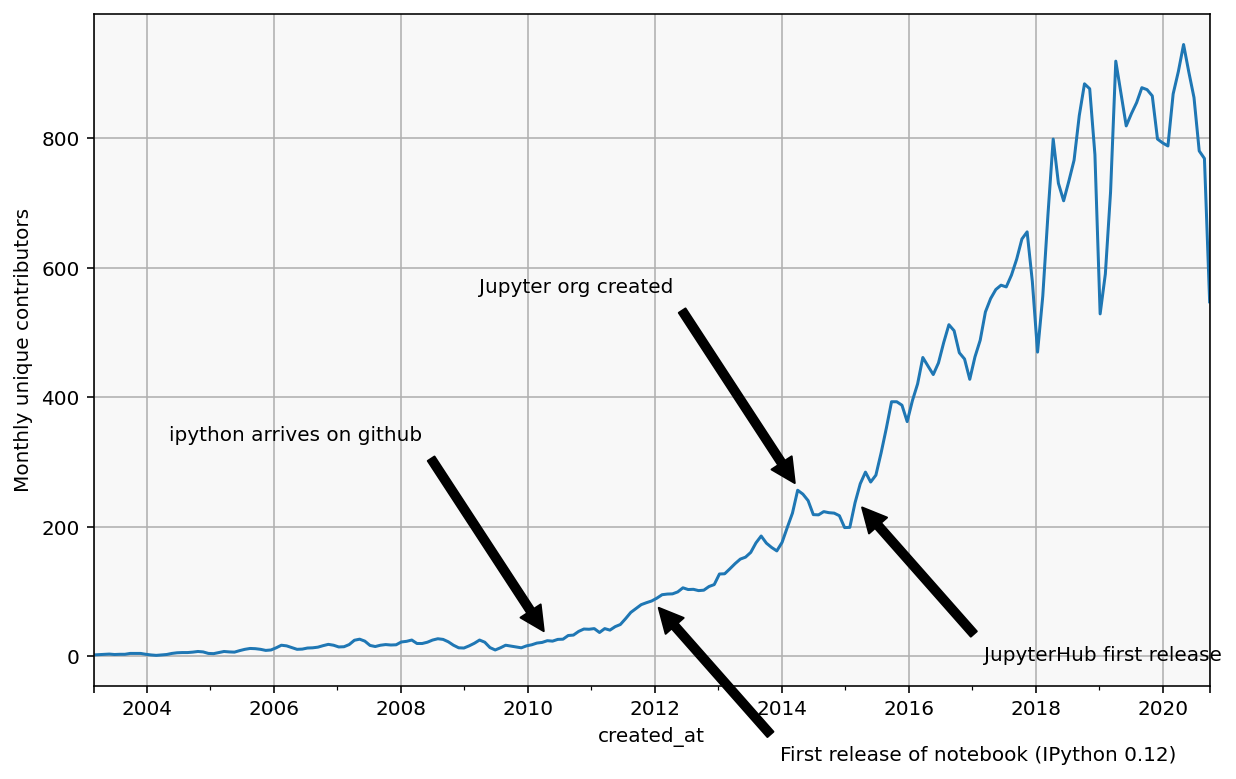

In [503]:
sample.plot(logy=False)
plt.ylabel("Monthly unique contributors")
add_lines(sample)

In [504]:
def plot_events(df, events=None, org=None, since=None, year=None, n=5, groupby="repo_name", metric="total", **plot_args):
    if events:
        if isinstance(events, str):
            events = [events]
        df = df[df.type.isin(events)]
    if org:
        df = df[df.org == org]
    if since:
        df = df[df.created_at >= since]
    if year:
        df = df[df.created_at.dt.year == year]
    grouped = df.groupby(groupby)
    if metric == "total":
        data = grouped.actor_id.count()
    elif metric == "unique":
        data = grouped.actor_id.nunique()
    else:
        raise ValueError(f"metric must be 'total' or 'unique', not {metric!r}")
    plot_args.setdefault("kind", "bar")
    data.nlargest(n).plot(**plot_args)
    

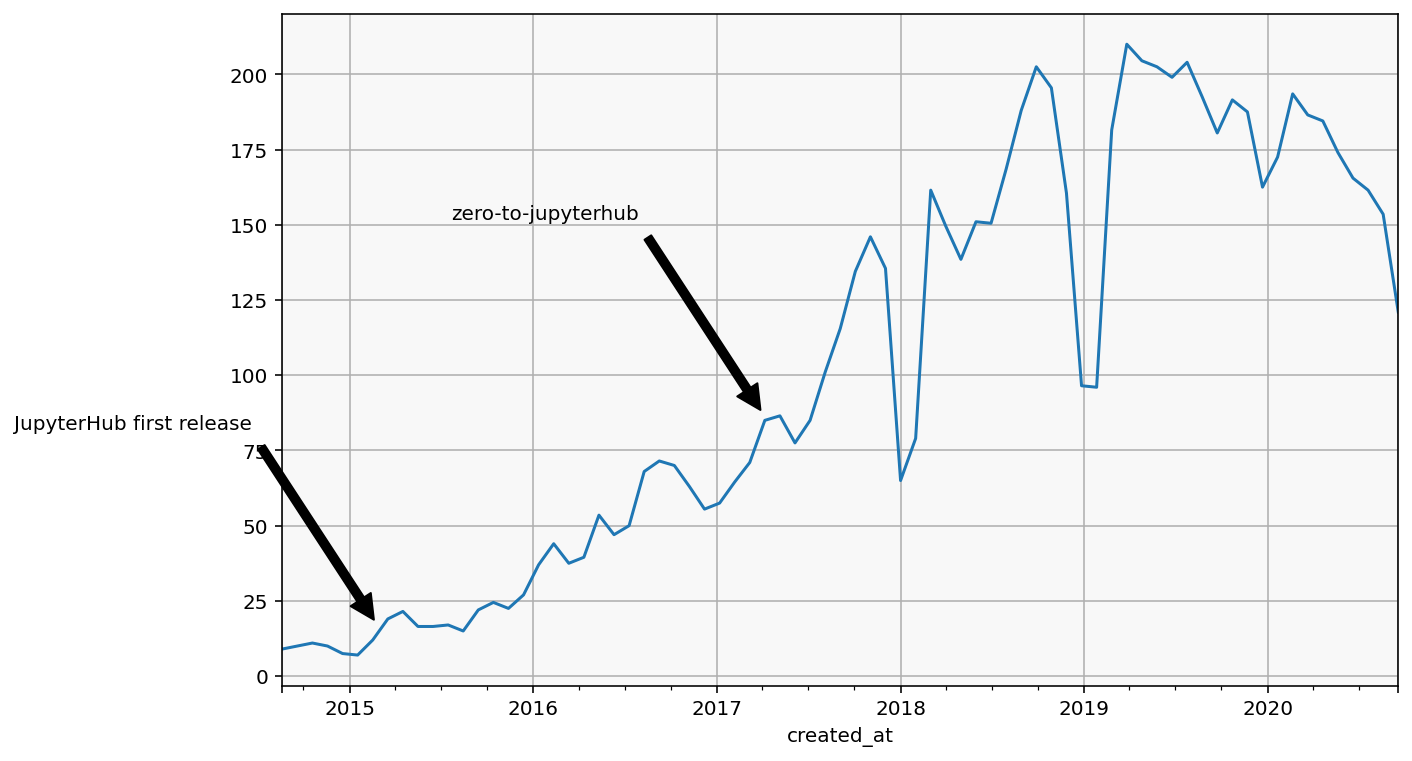

In [505]:
hub = df[df.repo_name.str.contains("jupyterhub")].resample("30d", on="created_at").actor_id.nunique().rolling("45d").mean()
hub.plot()
add_lines(hub, {
  "2015-03-03": "JupyterHub first release",
  "2017-04-10": "zero-to-jupyterhub",
#   "2019-05-03": "JupyterHub 1.0",
}, alternate=False)

<AxesSubplot:xlabel='created_at'>

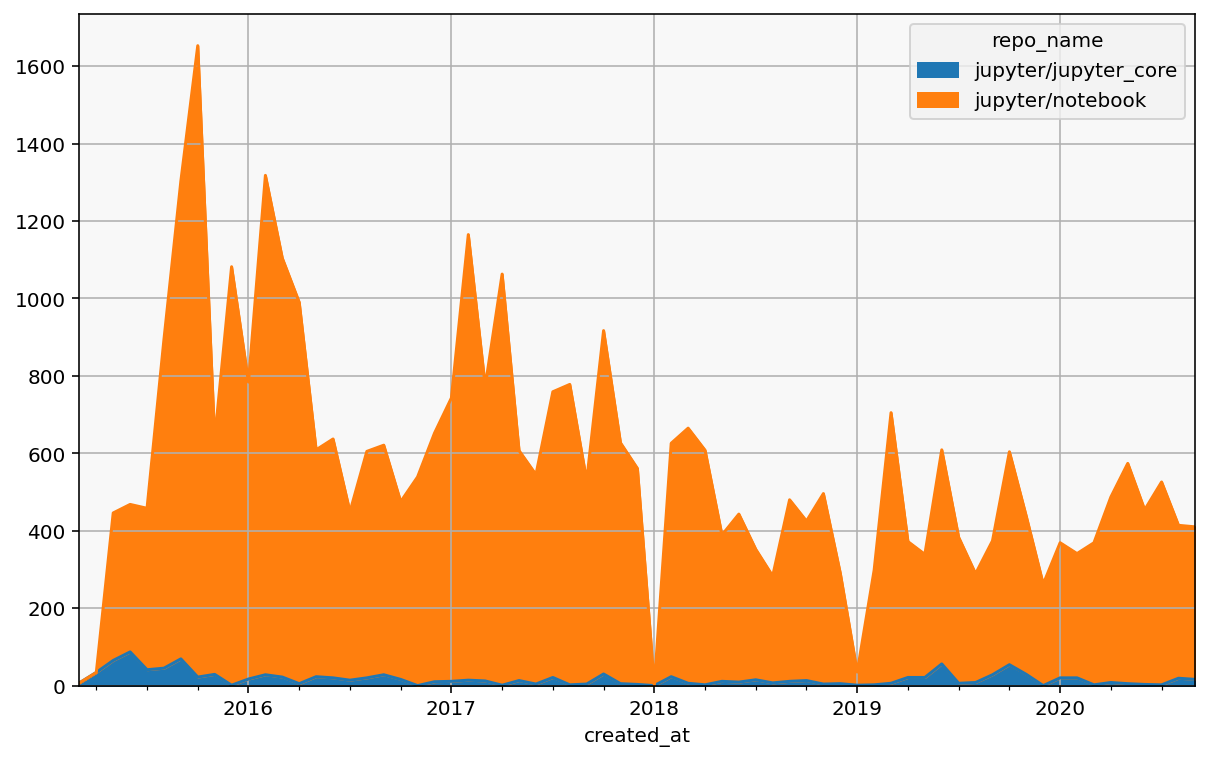

In [576]:
repos = ["jupyter/notebook", "jupyter/jupyter_core"]
subset = df[df.repo_name.isin(repos) & (df.created_at.dt.year >= 2012)]
grouped = subset.groupby([pd.Grouper(freq="M", key="created_at"), "repo_name"])
grouped.actor_id.count().unstack(-1).plot.area()

In [579]:
grouped.actor_id.count().unstack(-1)["jupyter/notebook"]

created_at
2012-01-31 00:00:00+00:00      NaN
2012-02-29 00:00:00+00:00      NaN
2012-03-31 00:00:00+00:00      NaN
2012-04-30 00:00:00+00:00      NaN
2012-05-31 00:00:00+00:00      NaN
                             ...  
2020-05-31 00:00:00+00:00    569.0
2020-06-30 00:00:00+00:00    451.0
2020-07-31 00:00:00+00:00    524.0
2020-08-31 00:00:00+00:00    395.0
2020-09-30 00:00:00+00:00    394.0
Freq: M, Name: jupyter/notebook, Length: 105, dtype: float64

<AxesSubplot:xlabel='created_at'>

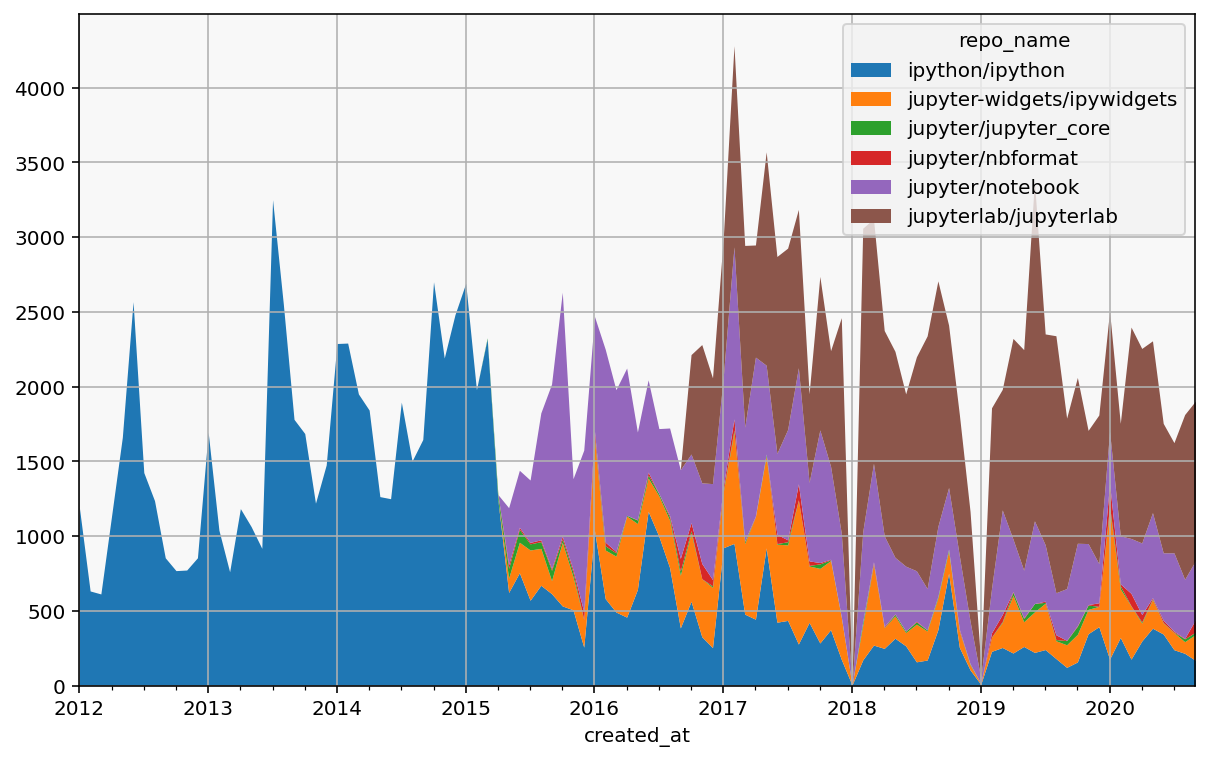

In [581]:
repos = ["ipython/ipython", "jupyter/jupyter_core", "jupyter/nbformat", "jupyter/notebook", "jupyter-widgets/ipywidgets", "jupyterlab/jupyterlab"]
subset = df[df.repo_name.isin(repos) & (df.created_at.dt.year >= 2012)]
grouped = subset.groupby([pd.Grouper(freq="M", key="created_at"), "repo_name"])
grouped.actor_id.count().unstack(-1).fillna(0).plot.area(linewidth=0)

In [517]:
repos

['ipython/ipython',
 'jupyter/jupyter_core',
 'jupyter/nbformat',
 'jupyter/notebook',
 'jupyter-widgets/ipywidgets']

In [521]:
df[df.repo_name.isin(repos) & (df.created_at.dt.year >= 2014)].groupby("repo_name").actor_id.count()



repo_name
ipython/ipython               57936
jupyter-widgets/ipywidgets    19823
jupyter/jupyter_core           1156
jupyter/nbformat               1498
jupyter/notebook              37384
Name: actor_id, dtype: int64

<AxesSubplot:xlabel='org'>

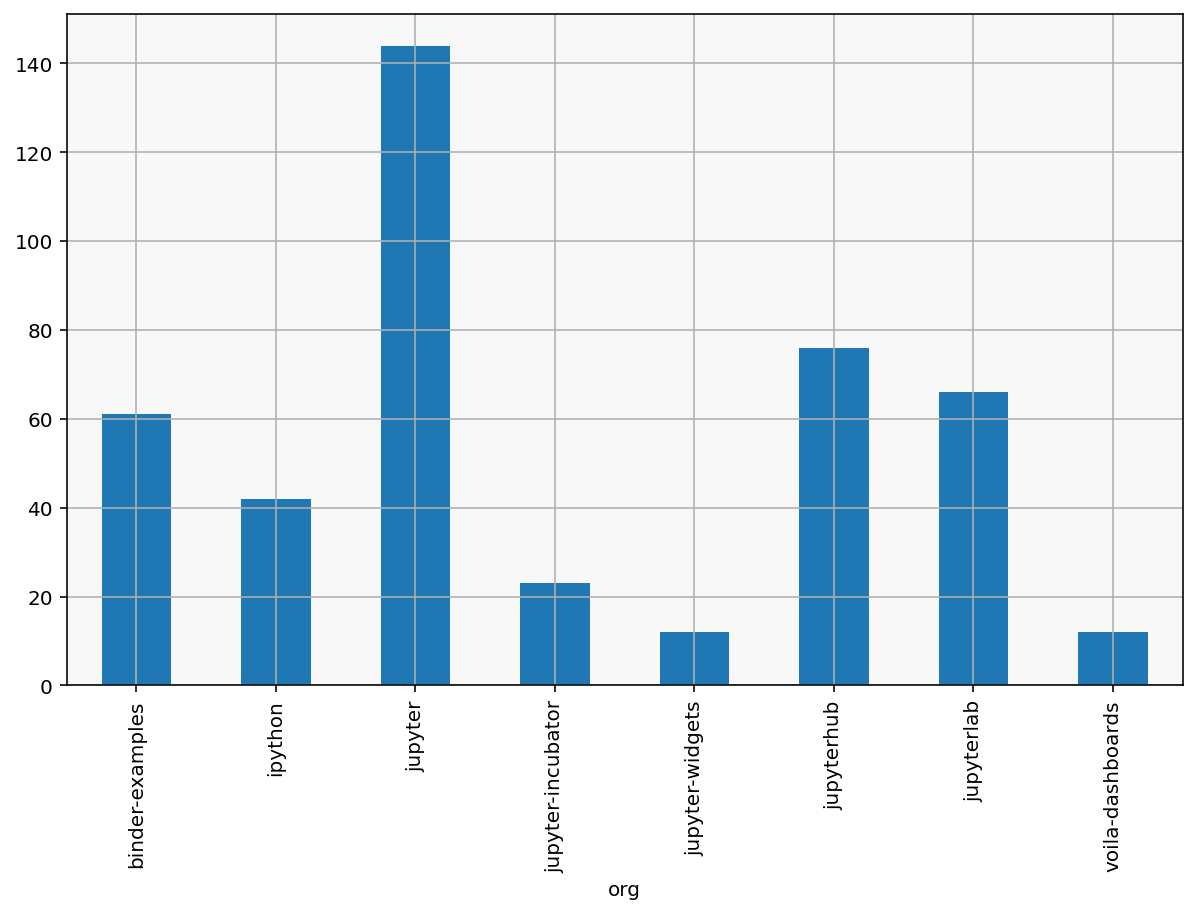

In [449]:
df.groupby("org").repo_name.nunique().plot(kind="bar")

<AxesSubplot:xlabel='org'>

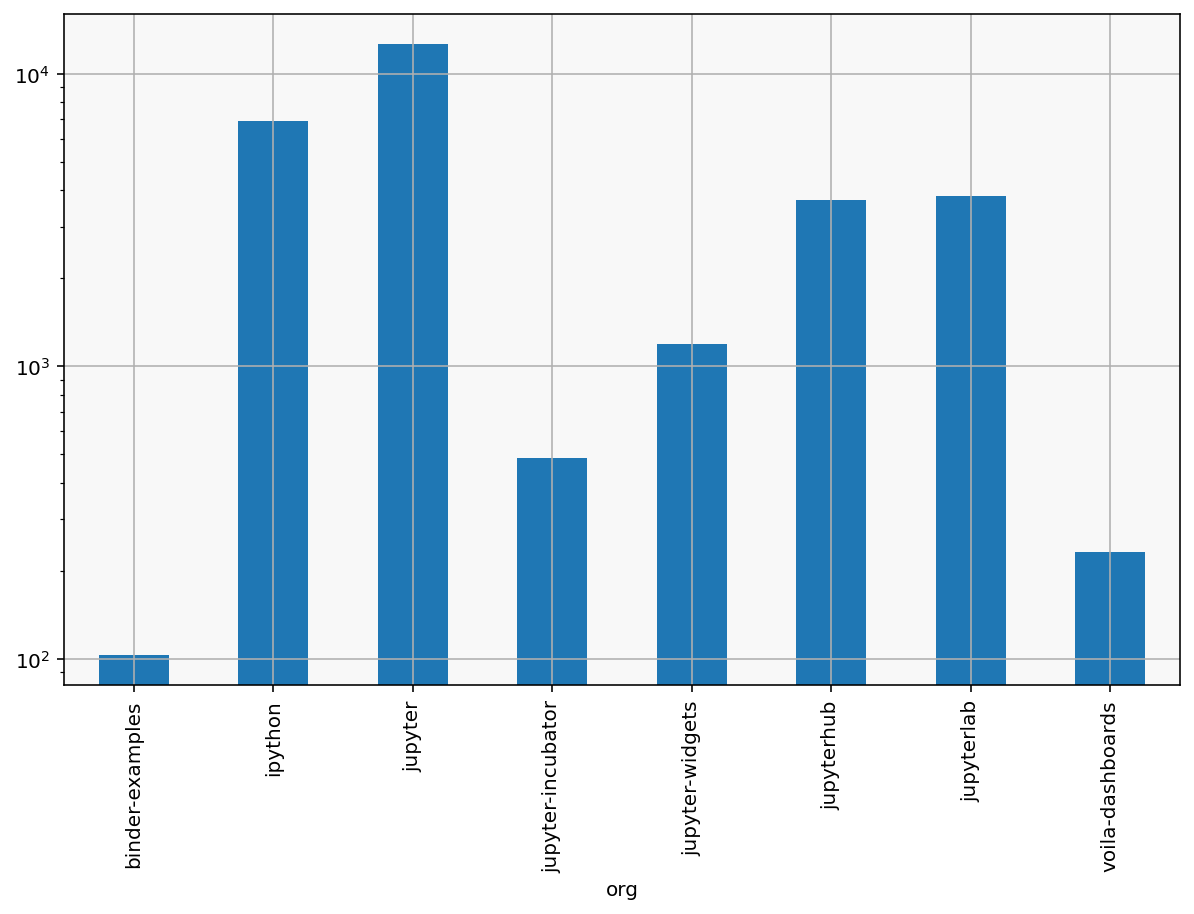

In [450]:
df.groupby("org").actor_id.nunique().plot(kind="bar", logy=True)

<AxesSubplot:xlabel='org'>

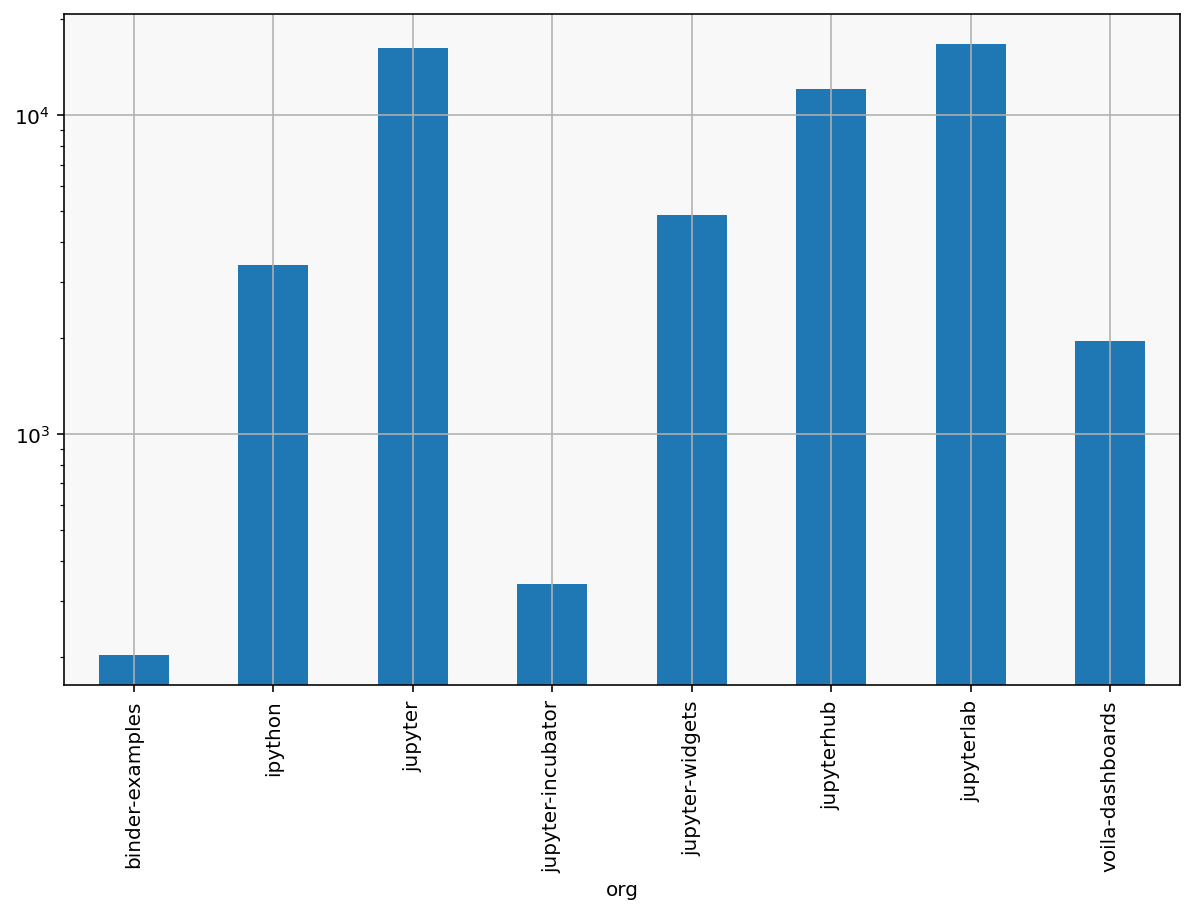

In [451]:
df[df.created_at.dt.year==2020].groupby("org").actor_id.count().plot(kind="bar", logy=True)

In [446]:
plot_events(df, groupby="org", year=2020, metric="total", logy=True)


TypeError: plot_events() got an unexpected keyword argument 'logy'

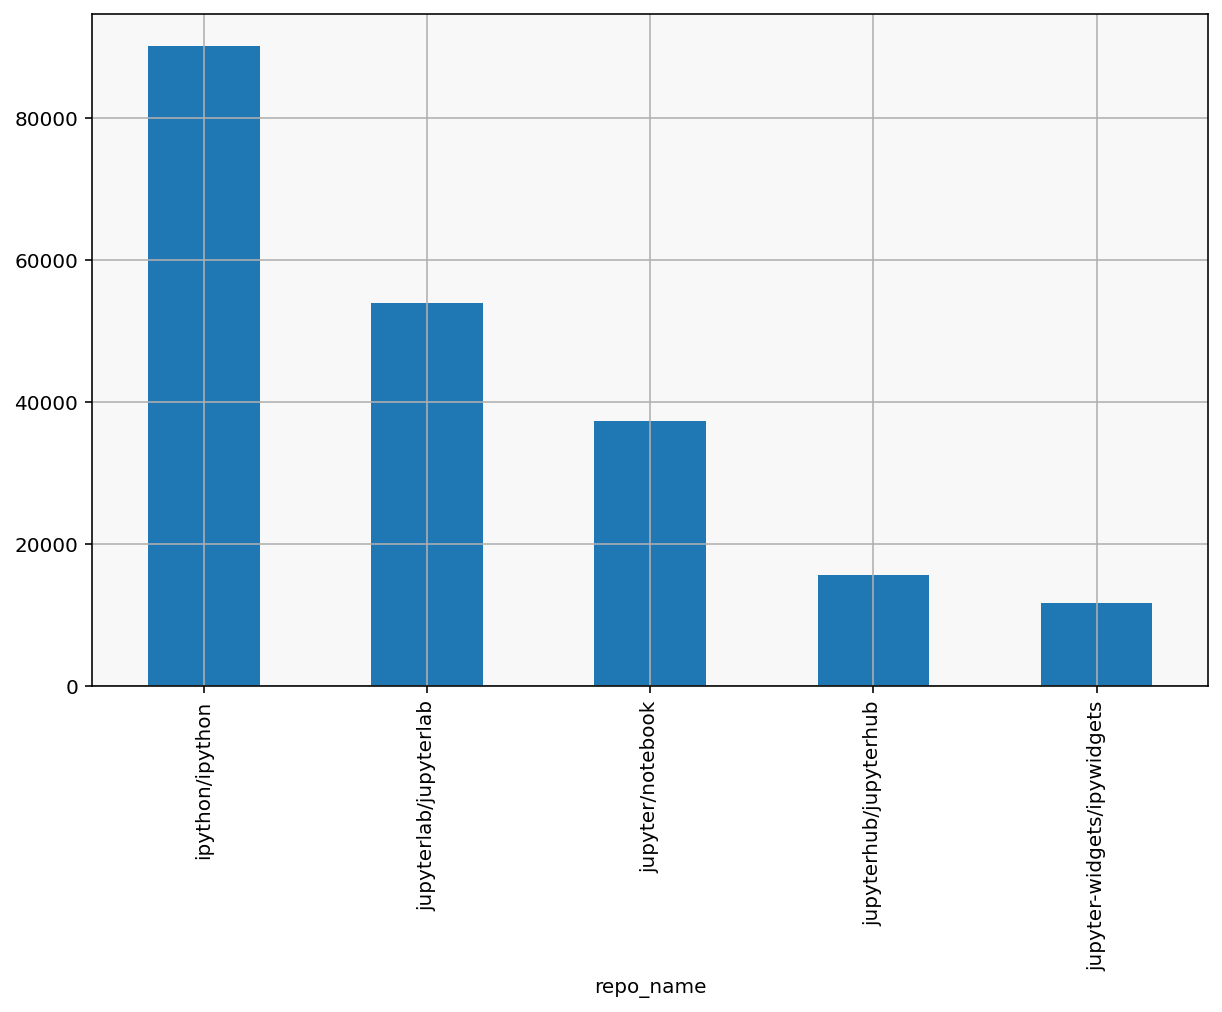

In [186]:
plot_events(df)

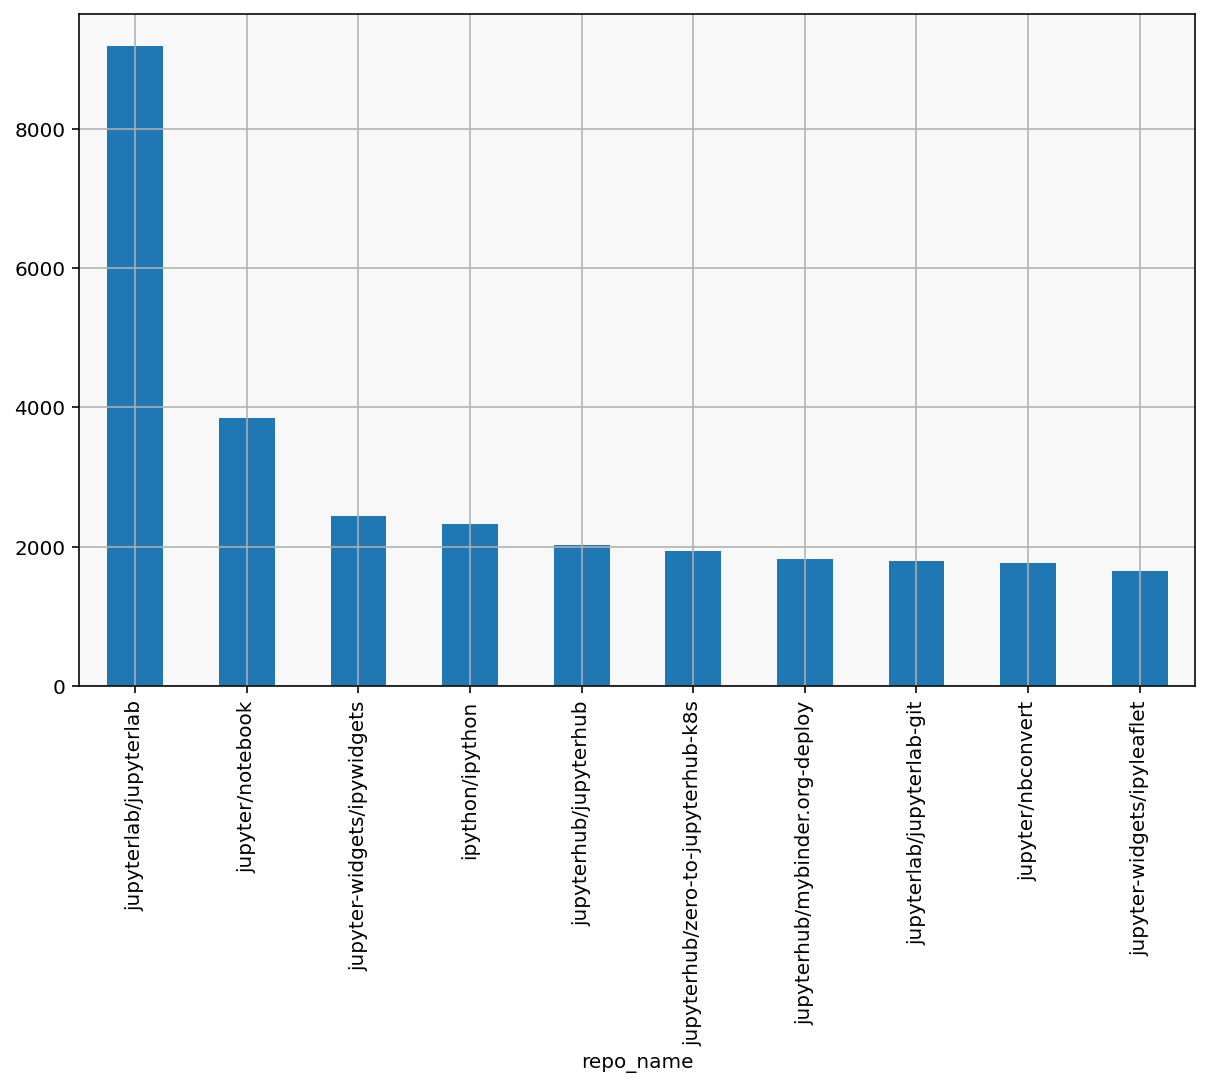

In [302]:
plot_events(df, year=2020, n=10)

<AxesSubplot:xlabel='repo_name'>

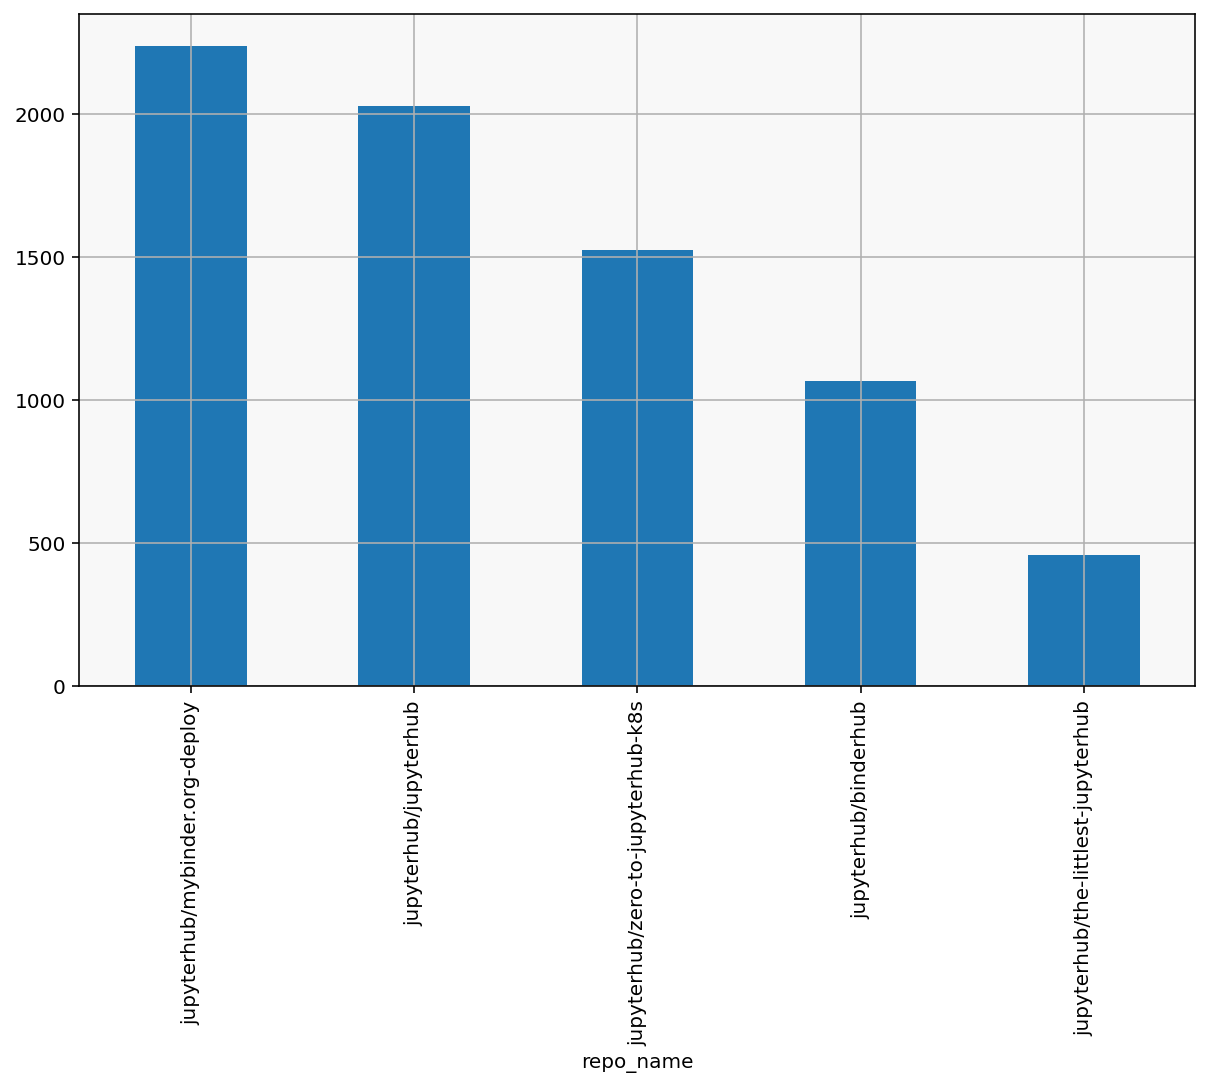

In [303]:
hub_prs = df[(df.type=="PullRequestEvent") & (df.org=="jupyterhub")]
hub_prs.groupby("repo_name").actor_id.count().nlargest(5).plot(kind="bar")

<AxesSubplot:xlabel='repo_name'>

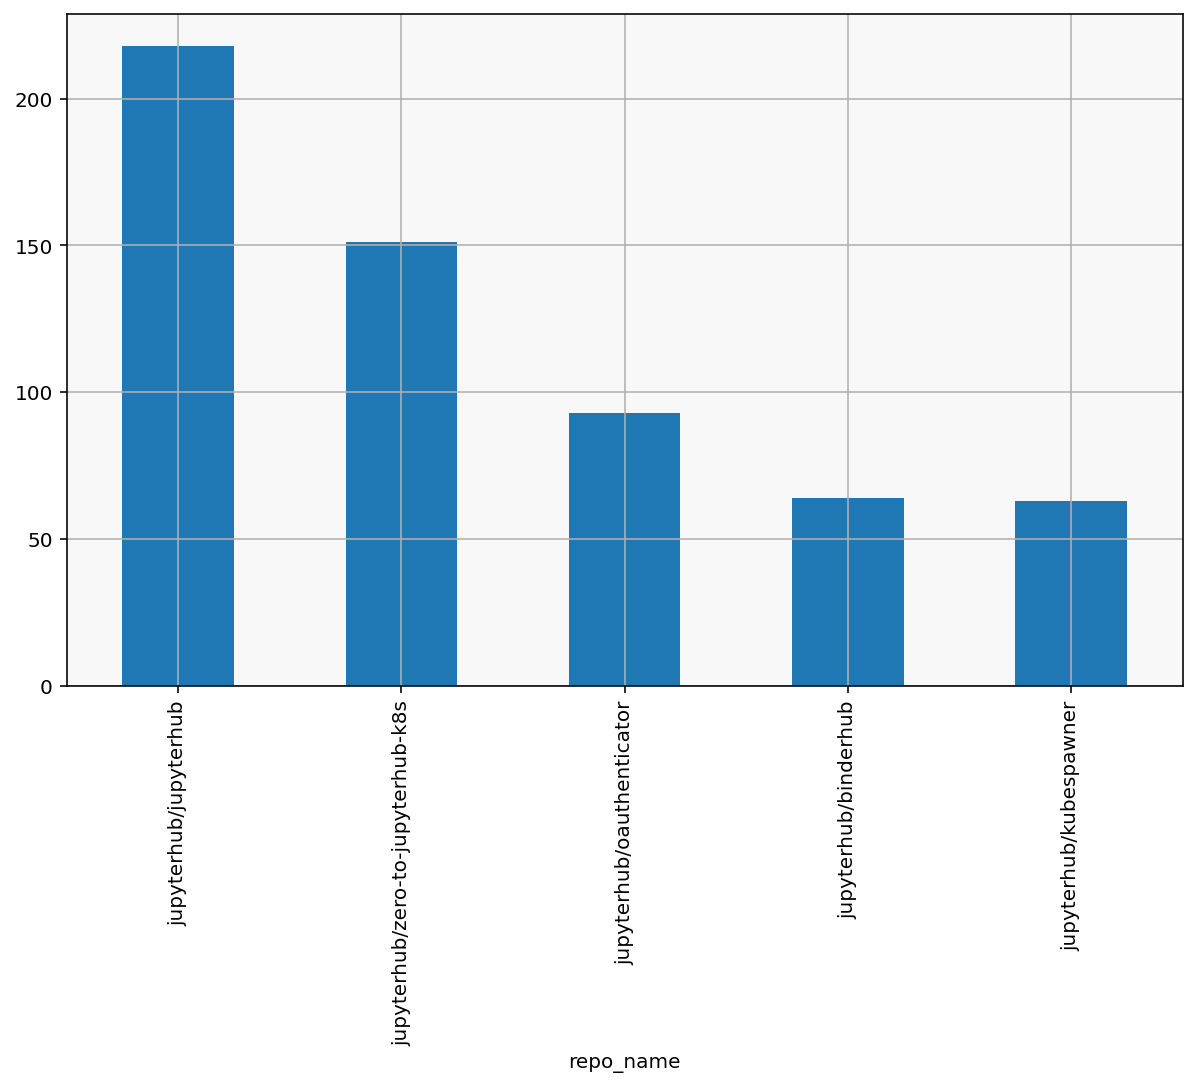

In [304]:
hub_prs.groupby("repo_name").actor_id.nunique().nlargest(5).plot(kind="bar")

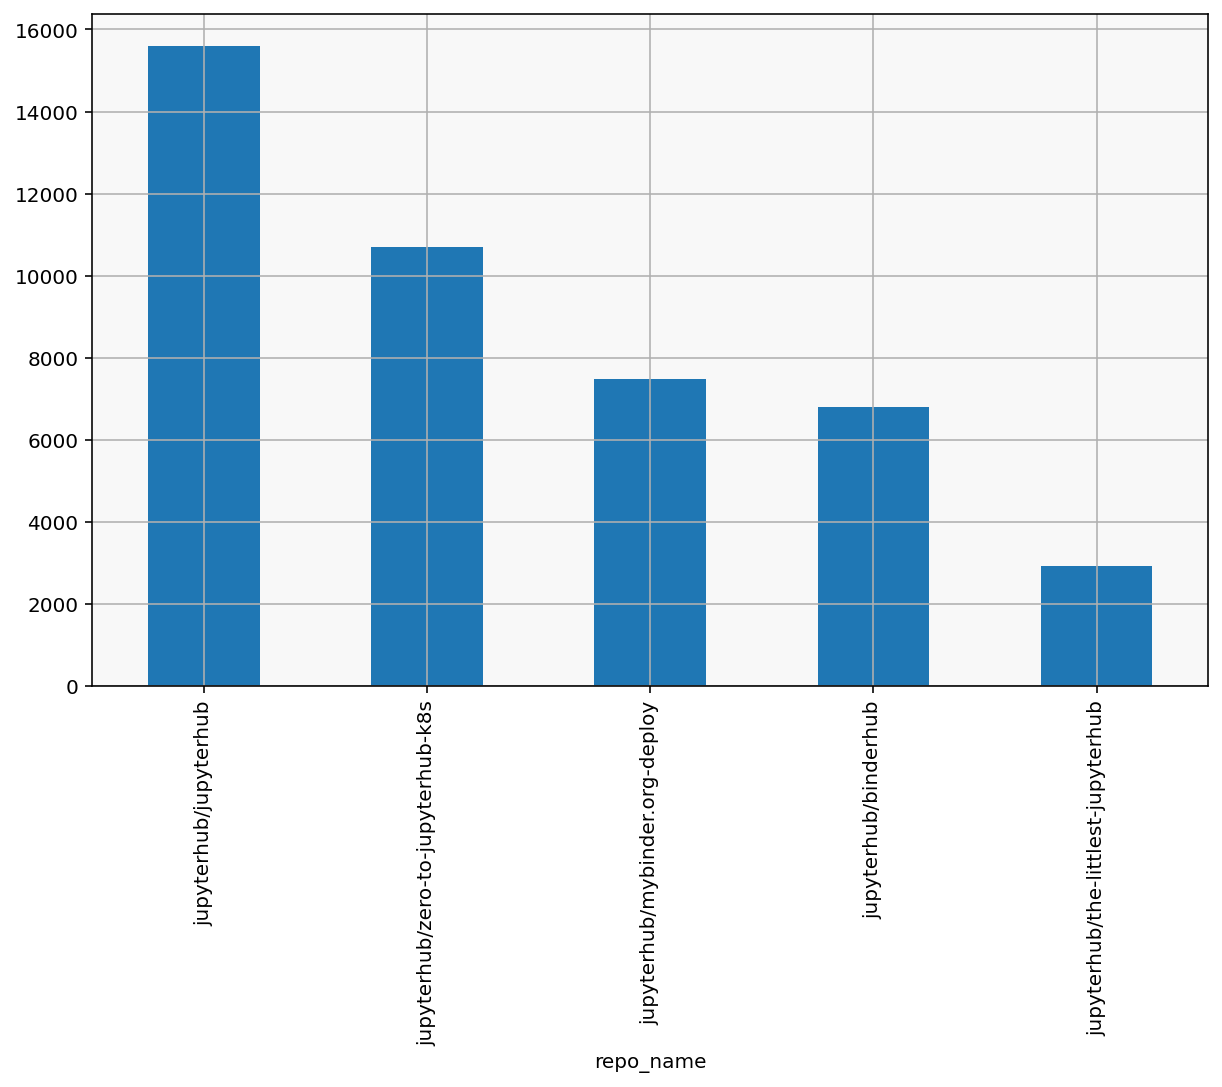

In [180]:
plot_events(df, org="jupyterhub")

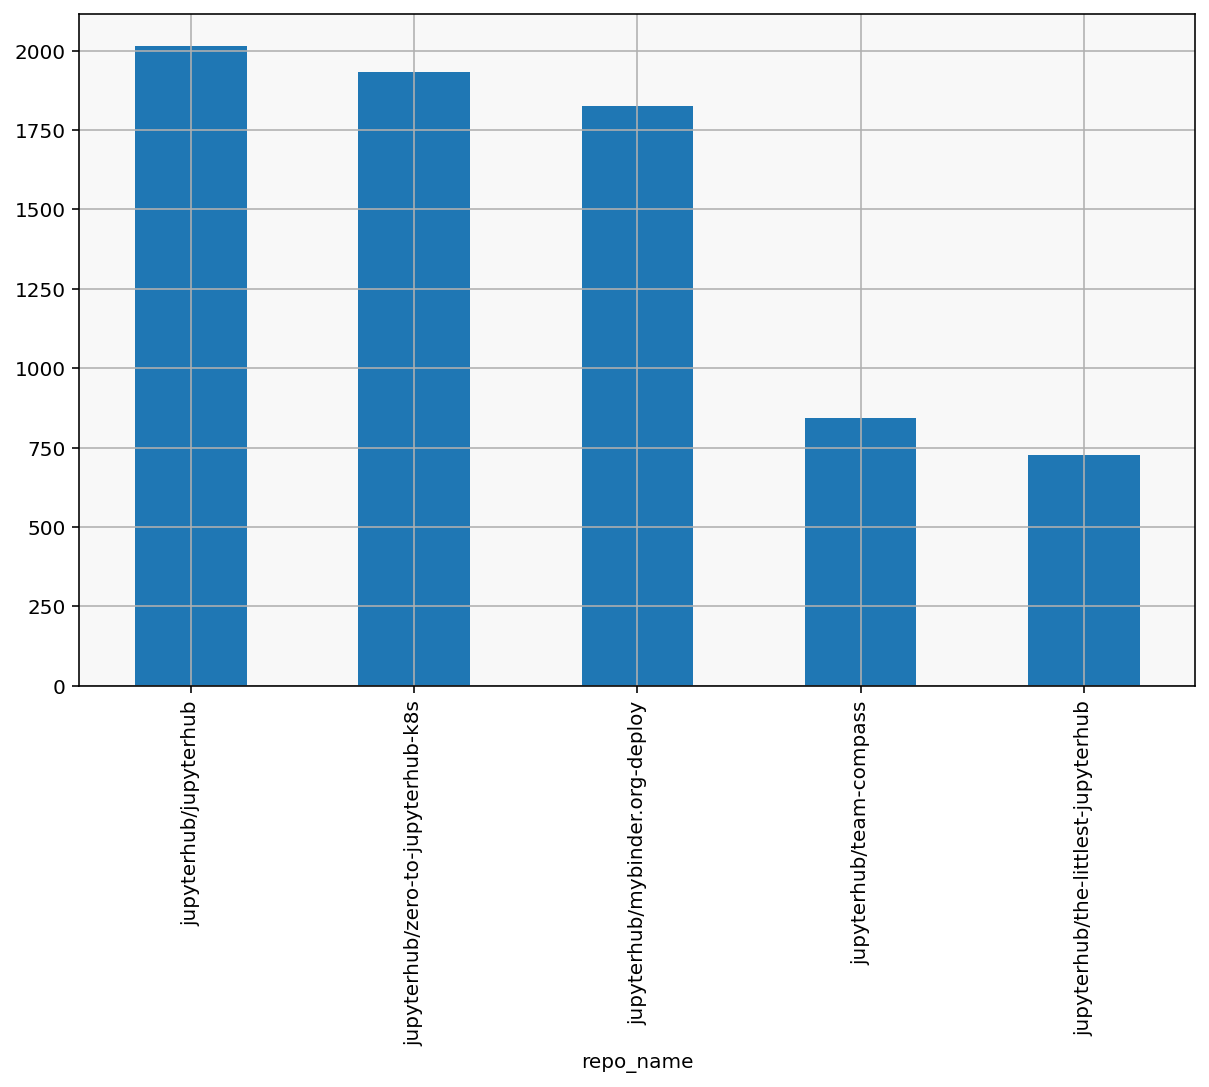

In [182]:
plot_events(df, org="jupyterhub", year=2020)

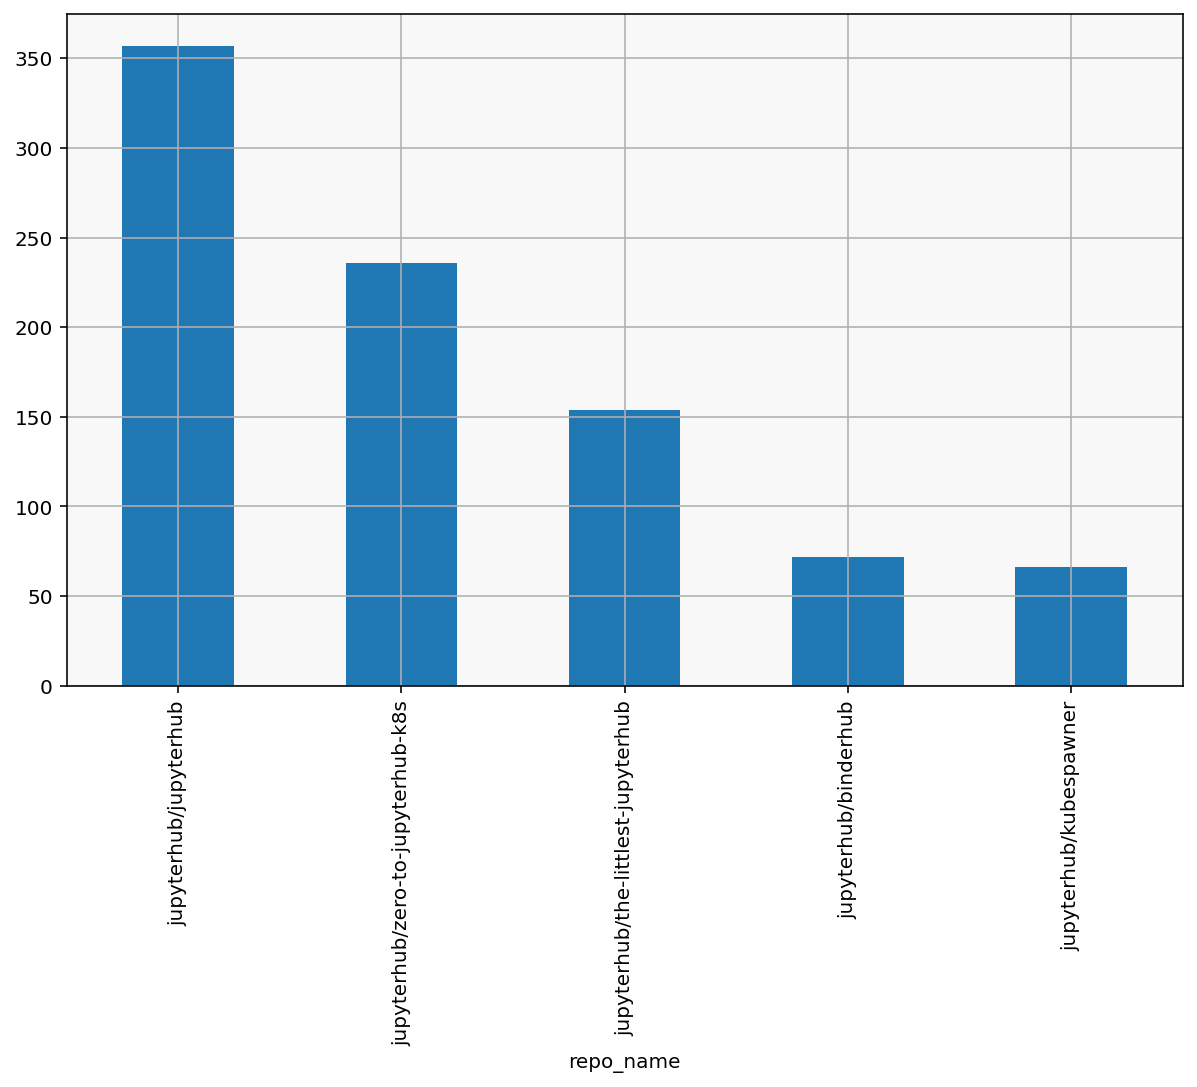

In [183]:
plot_events(df, org="jupyterhub", year=2020, metric="unique")

In [173]:
df.created_at >= "2020"

4527    False
4528    False
4530    False
4531    False
4533    False
        ...  
9650     True
9651     True
9652     True
9653     True
9656     True
Name: created_at, Length: 437681, dtype: bool

<AxesSubplot:xlabel='repo_name'>

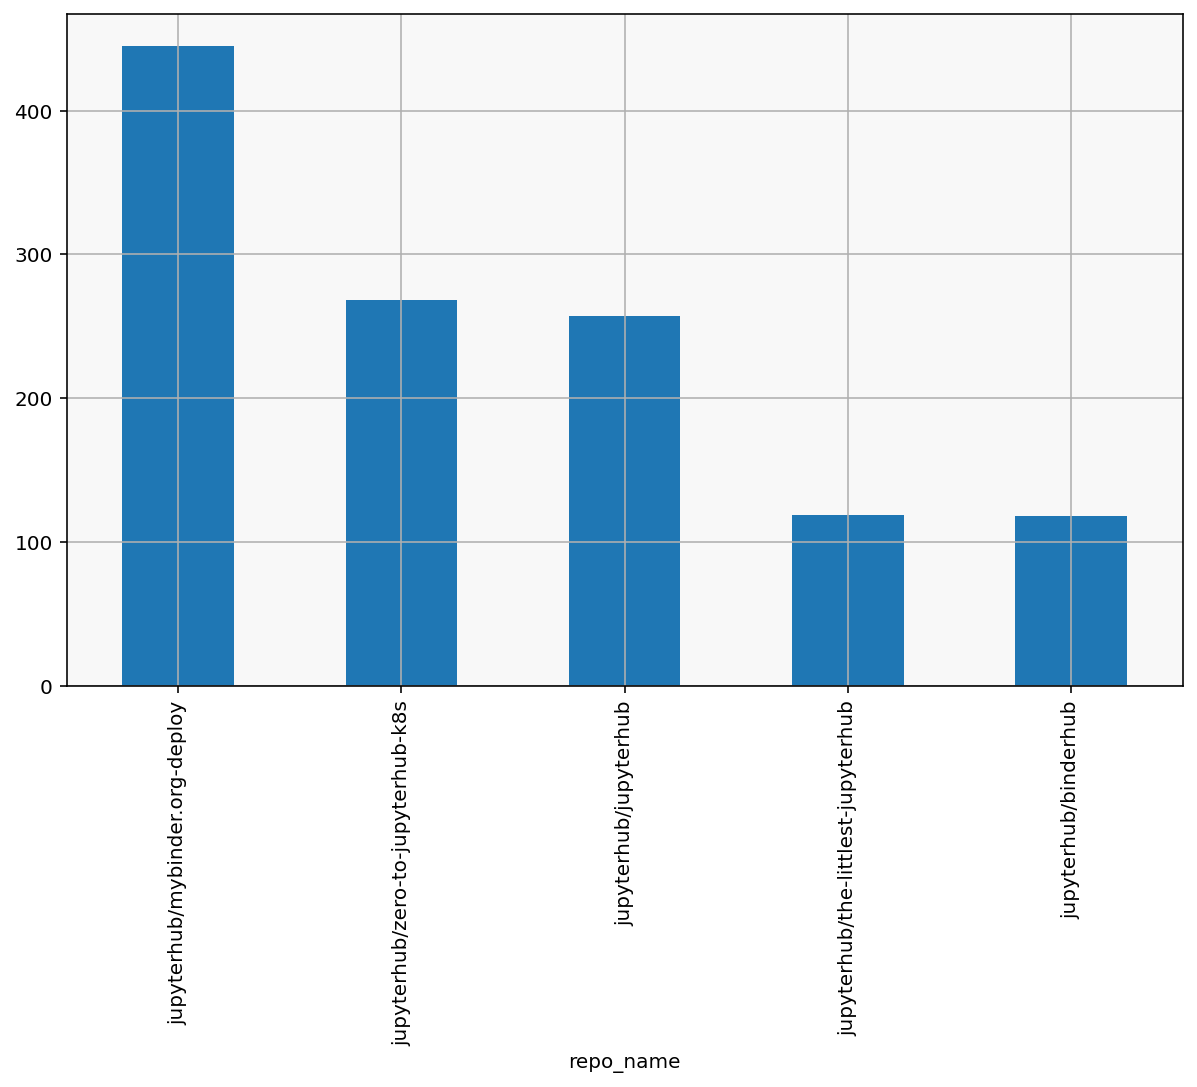

In [171]:
hub_prs_2020 = df[(df.type=="PullRequestEvent") & (df.org=="jupyterhub") & (df.created_at.dt.year == 2020)]
hub_prs_2020.groupby("repo_name").actor_id.count().nlargest(5).plot(kind="bar")

<AxesSubplot:xlabel='repo_name'>

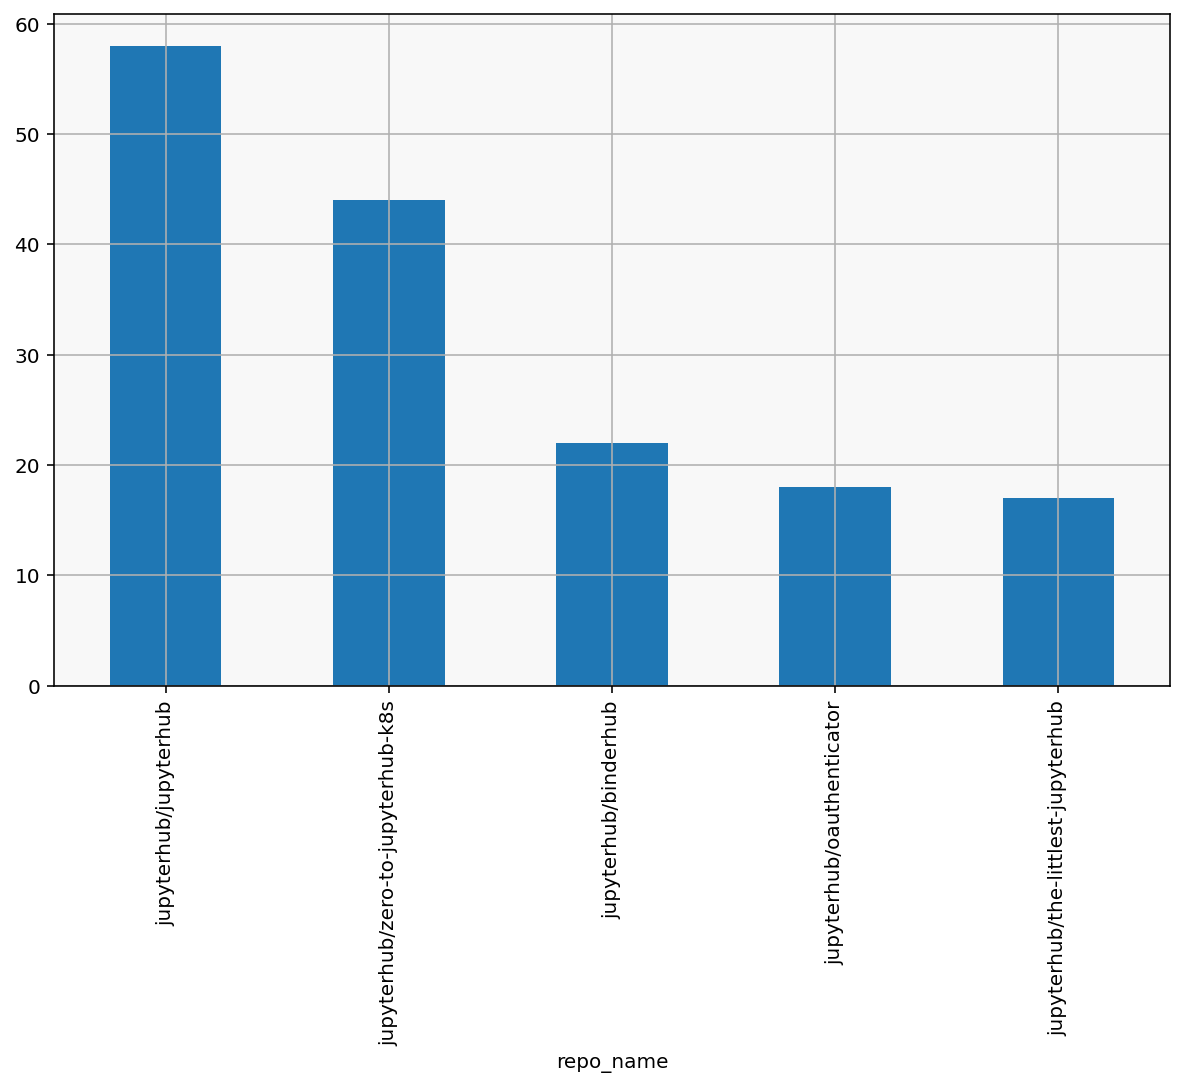

In [170]:
df[(df.type=="PullRequestEvent") & (df.org=="jupyterhub") & (df.created_at.dt.year == 2020)].groupby("repo_name").actor_login.nunique().nlargest(5).plot(kind="bar")

<AxesSubplot:xlabel='repo_name'>

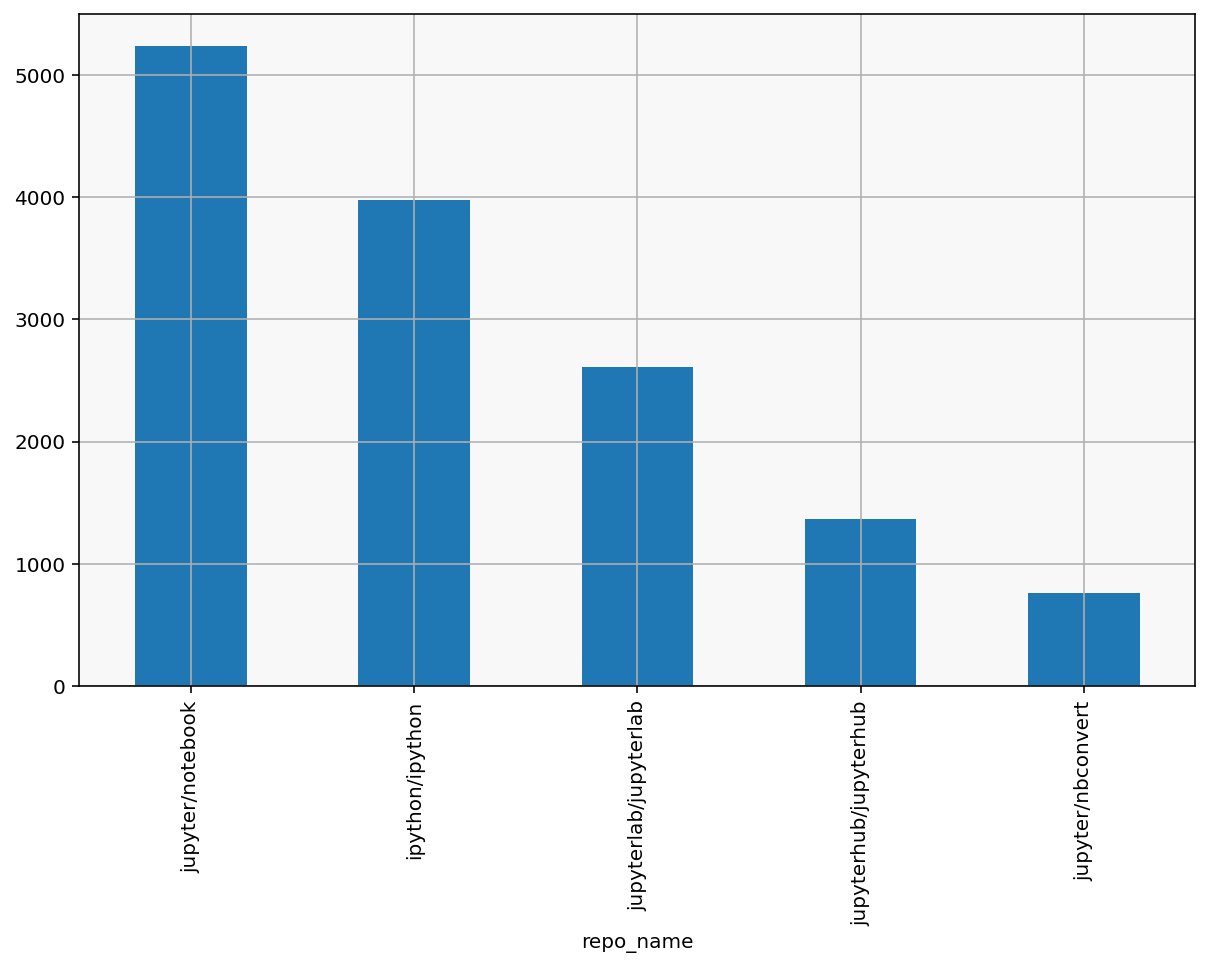

In [36]:
df[df.type.str.contains("Comment")].groupby("repo_name").actor_id.nunique().nlargest(5).plot(kind="bar")

In [ ]:
contribution_counts = df.actor_id.value_counts()
contribution_counts.value_counts()[:10].plot(kind="bar")

In [ ]:
flyby = contribution_counts[contribution_counts <= 2]
flyby

In [ ]:
df[df.actor_id.isin(flyby.index)].type.value_counts()

In [38]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
gr

In [53]:
grouped_unique.index

MultiIndex([( 'binder-examples', '2011-10-04 00:00:00+00:00'),
            ( 'binder-examples', '2011-11-03 00:00:00+00:00'),
            ( 'binder-examples', '2011-12-03 00:00:00+00:00'),
            ( 'binder-examples', '2012-01-02 00:00:00+00:00'),
            ( 'binder-examples', '2012-02-01 00:00:00+00:00'),
            ( 'binder-examples', '2012-03-02 00:00:00+00:00'),
            ( 'binder-examples', '2012-04-01 00:00:00+00:00'),
            ( 'binder-examples', '2012-05-01 00:00:00+00:00'),
            ( 'binder-examples', '2012-05-31 00:00:00+00:00'),
            ( 'binder-examples', '2012-06-30 00:00:00+00:00'),
            ...
            ('voila-dashboards', '2015-01-10 00:00:00+00:00'),
            ('voila-dashboards', '2015-02-09 00:00:00+00:00'),
            ('voila-dashboards', '2015-03-11 00:00:00+00:00'),
            ('voila-dashboards', '2015-04-10 00:00:00+00:00'),
            ('voila-dashboards', '2015-05-10 00:00:00+00:00'),
            ('voila-dashboards', '2015-

<AxesSubplot:xlabel='org,created_at'>

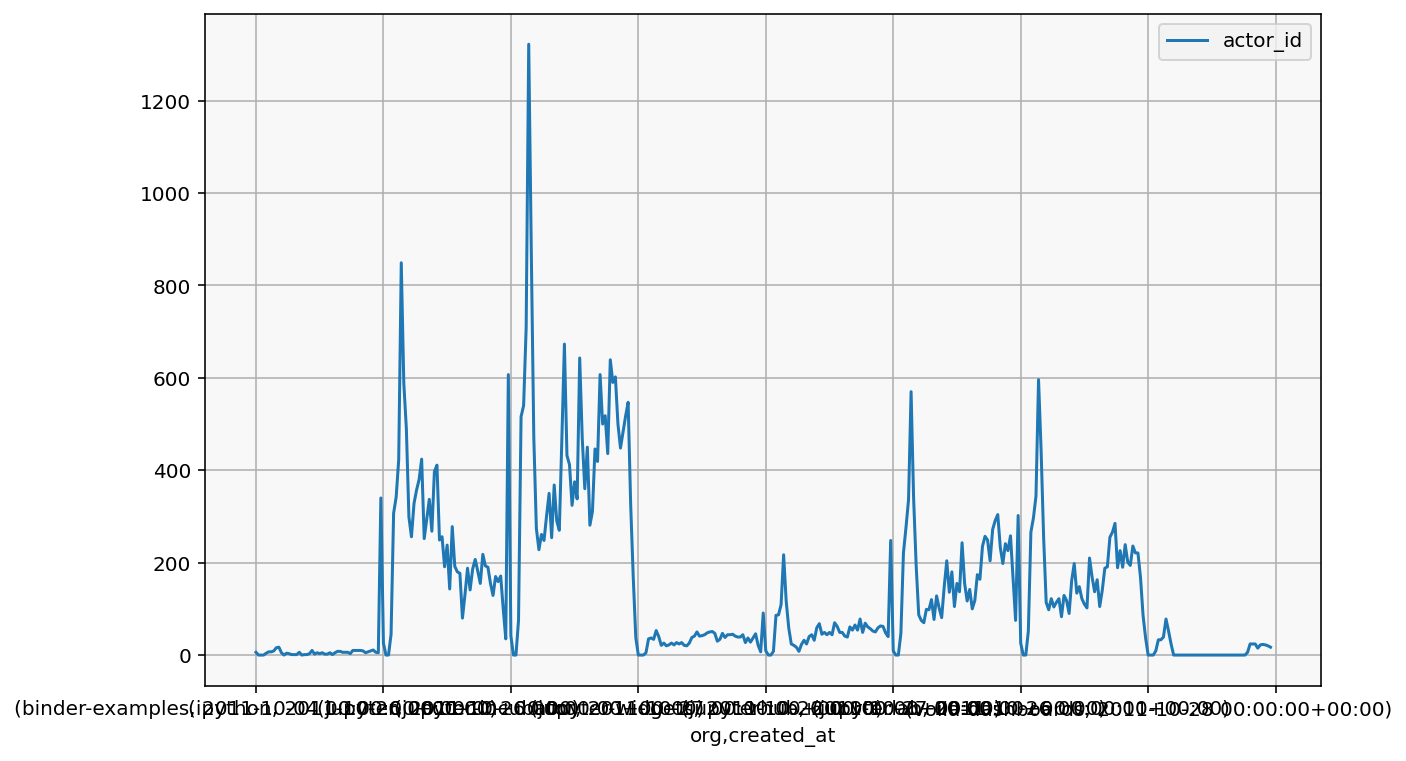

In [52]:
grouped_unique.plot(legend=True)

In [592]:
df.type.value_counts()

IssueCommentEvent                228730
PullRequestEvent                  61739
IssuesEvent                       54346
PushEvent                         52497
PullRequestReviewCommentEvent     34410
EmailEvent                        25191
PullRequestCommentEvent            8600
CreateEvent                        4548
GollumEvent                        2394
DeleteEvent                        2074
IssueEvent                         1468
PullRequestReviewEvent              739
CommitCommentEvent                  609
MemberEvent                         449
ReleaseEvent                        258
PublicEvent                          16
TeamAddEvent                         11
Name: type, dtype: int64

<AxesSubplot:xlabel='created_at'>

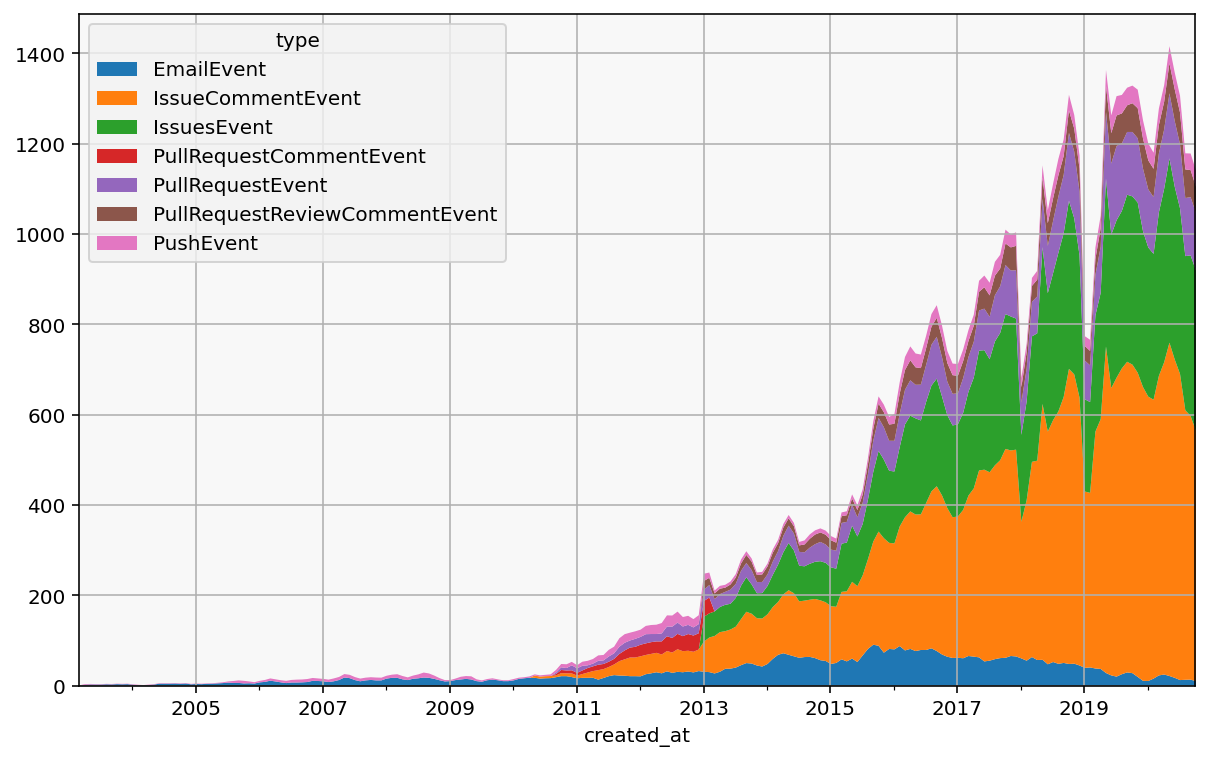

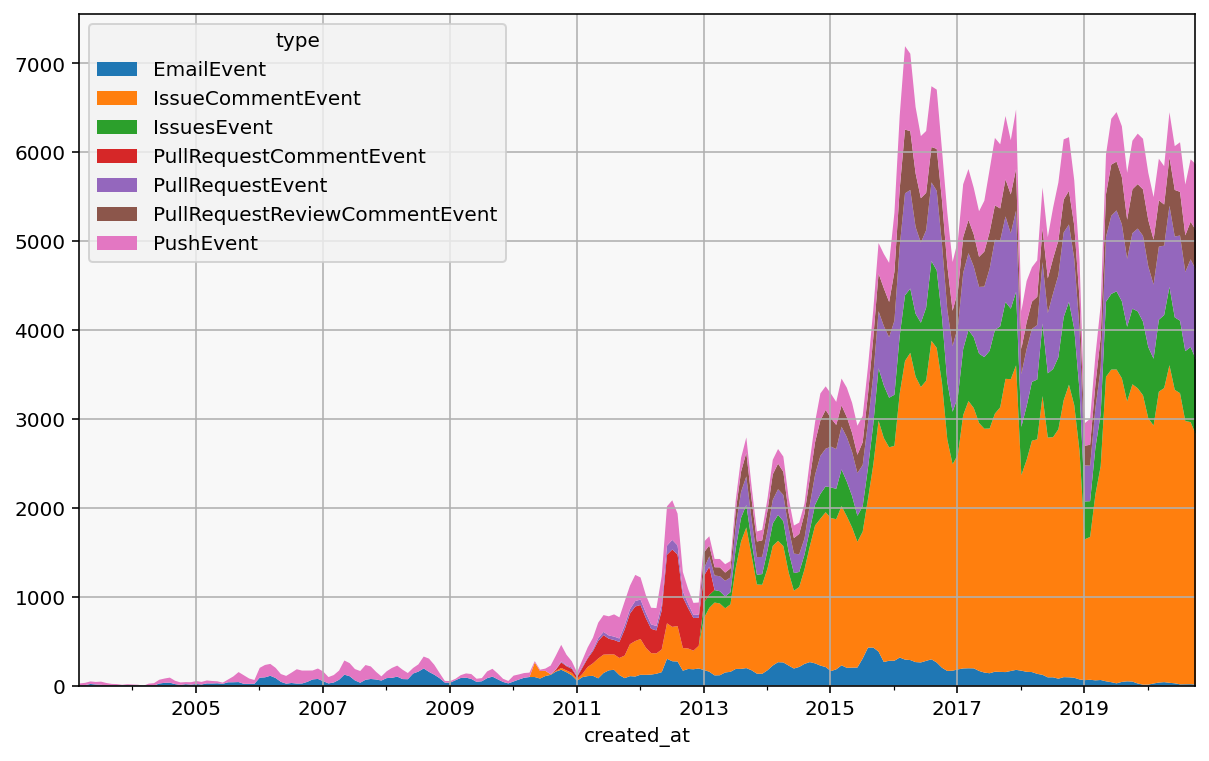

In [596]:
events = df.type.value_counts().index[:7]
subset = df[df.type.isin(events)]
grouped = subset.groupby([pd.Grouper(freq="M", key="created_at"), "type"])
grouped.actor_id.nunique().unstack(-1).rolling("90d").mean().plot.area(linewidth=0)
grouped.actor_id.count().unstack(-1).rolling("90d").mean().plot.area(linewidth=0)

In [ ]:
events = df.type.value_counts().index[:7]
subset = df[df.type.isin(events)]
grouped = subset.groupby([pd.Grouper(freq="M", key="created_at"), "type"])
grouped.actor_id.nunique().unstack(-1).rolling("90d").mean().plot.area(linewidth=0)

<AxesSubplot:xlabel='created_at'>

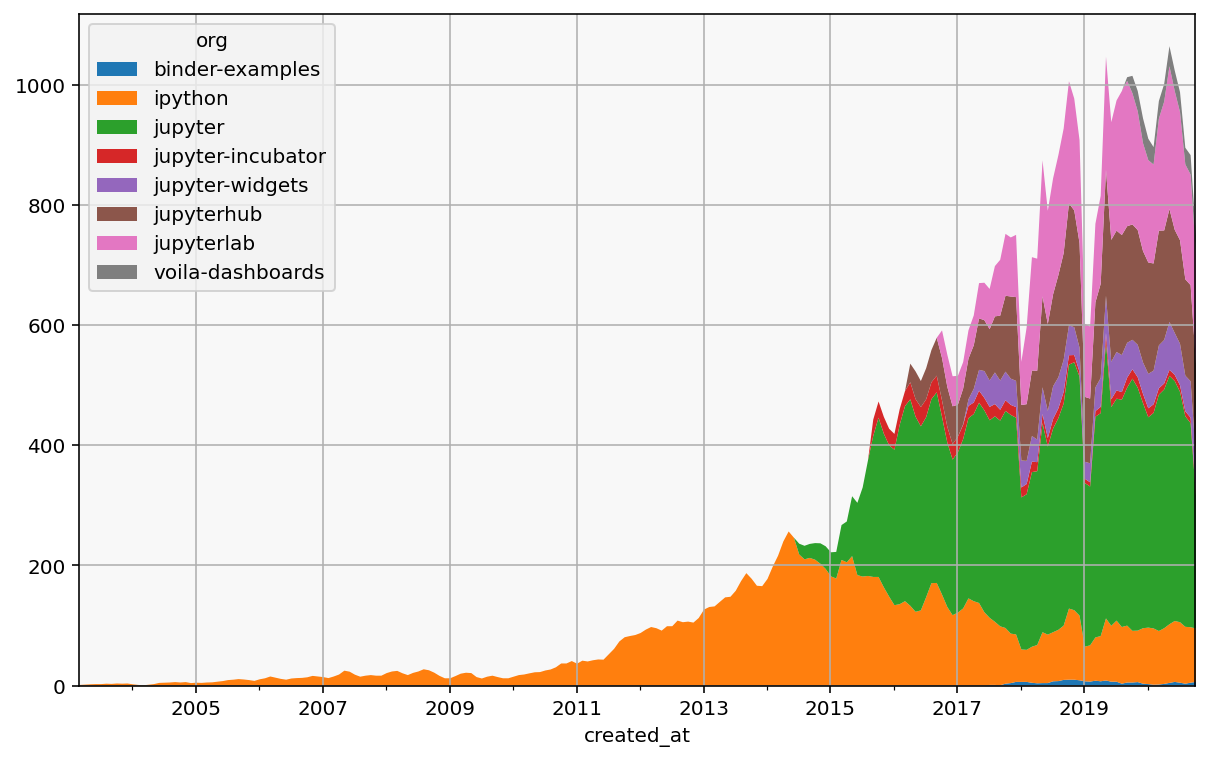

In [587]:
grouped = df.groupby([pd.Grouper(freq="M", key="created_at"), "org"])
grouped.actor_id.nunique().unstack(-1).rolling("90d").mean().plot.area(linewidth=0)


In [ ]:
hub_actual = df[df.repo_name=="jupyterhub/jupyterhub"]
hub_actual.resample("30d", on="created_at").actor_id.nunique().rolling("90d").mean().plot()

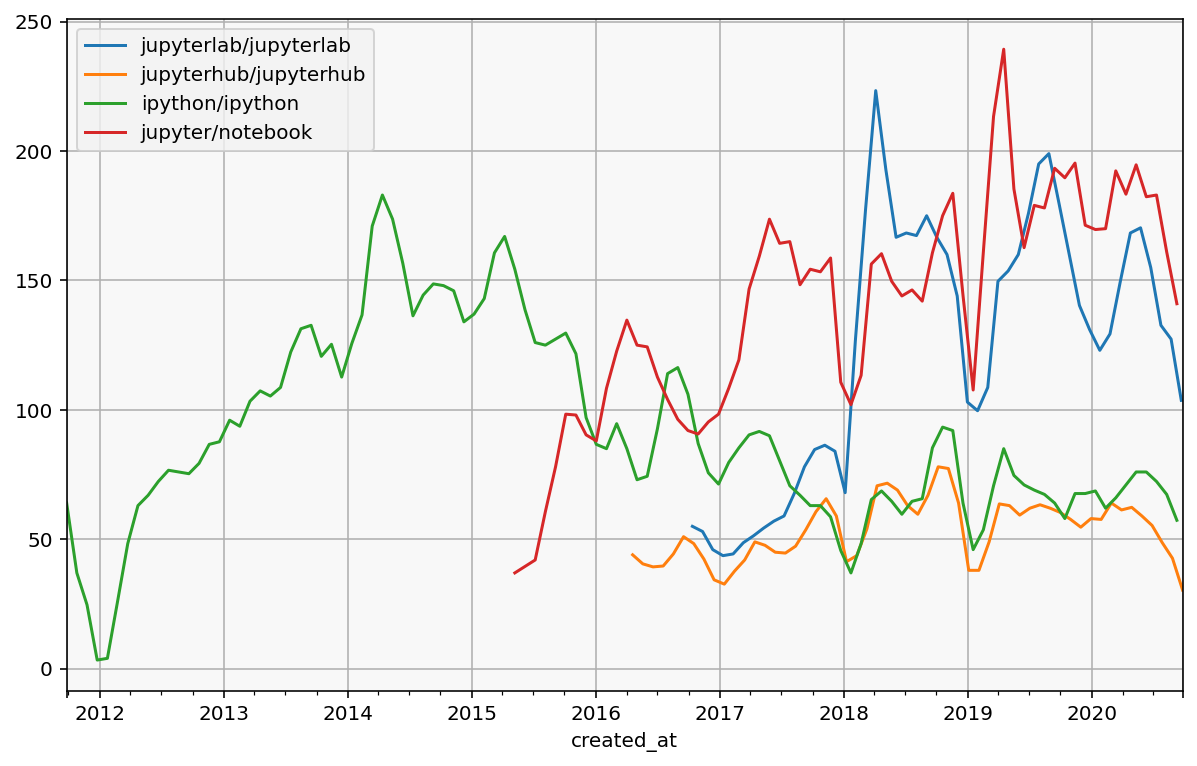

In [81]:
for repo in ["jupyterlab/jupyterlab", "jupyterhub/jupyterhub", "ipython/ipython", "jupyter/notebook"]:
    per_repo = df[df.repo_name==repo]
    per_repo.resample("30d", on="created_at").actor_id.nunique().rolling("90d").mean().plot(label=repo)
plt.legend()

<AxesSubplot:xlabel='created_at'>

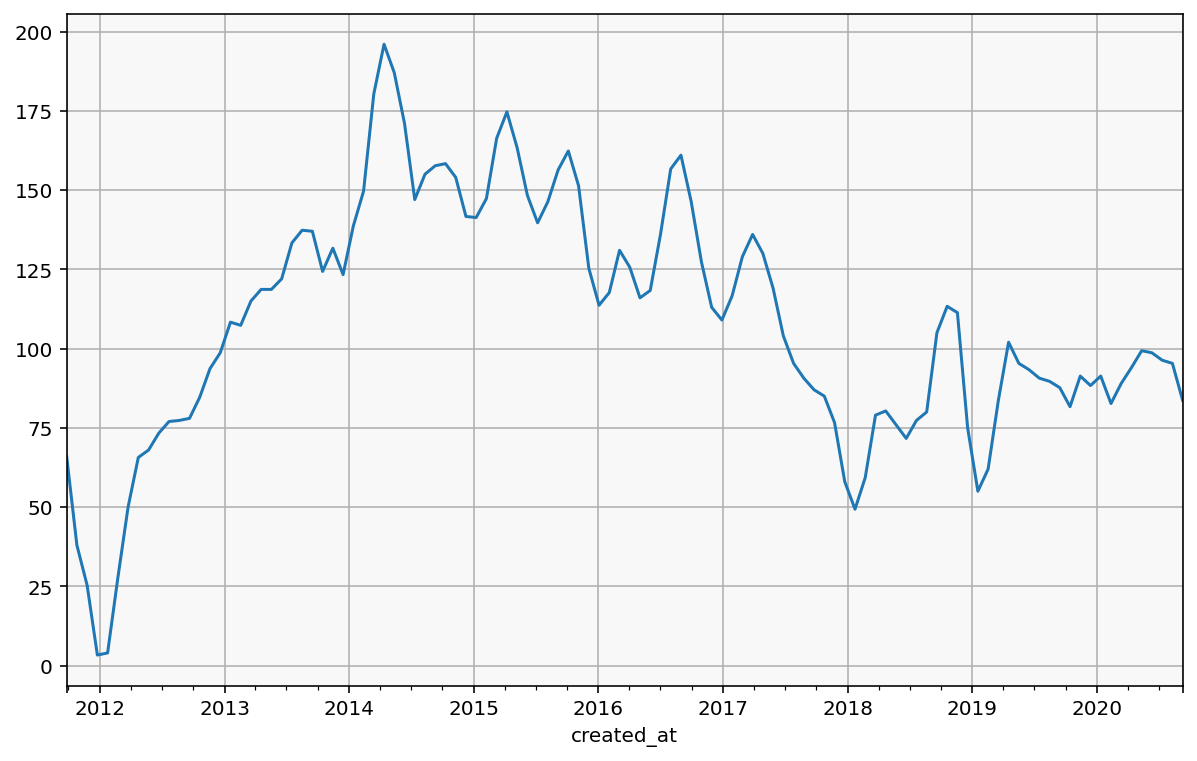

In [82]:
df[df.org=="ipython"].resample("30d", on="created_at").actor_id.nunique().rolling("90d").mean().plot()

<AxesSubplot:xlabel='created_at'>

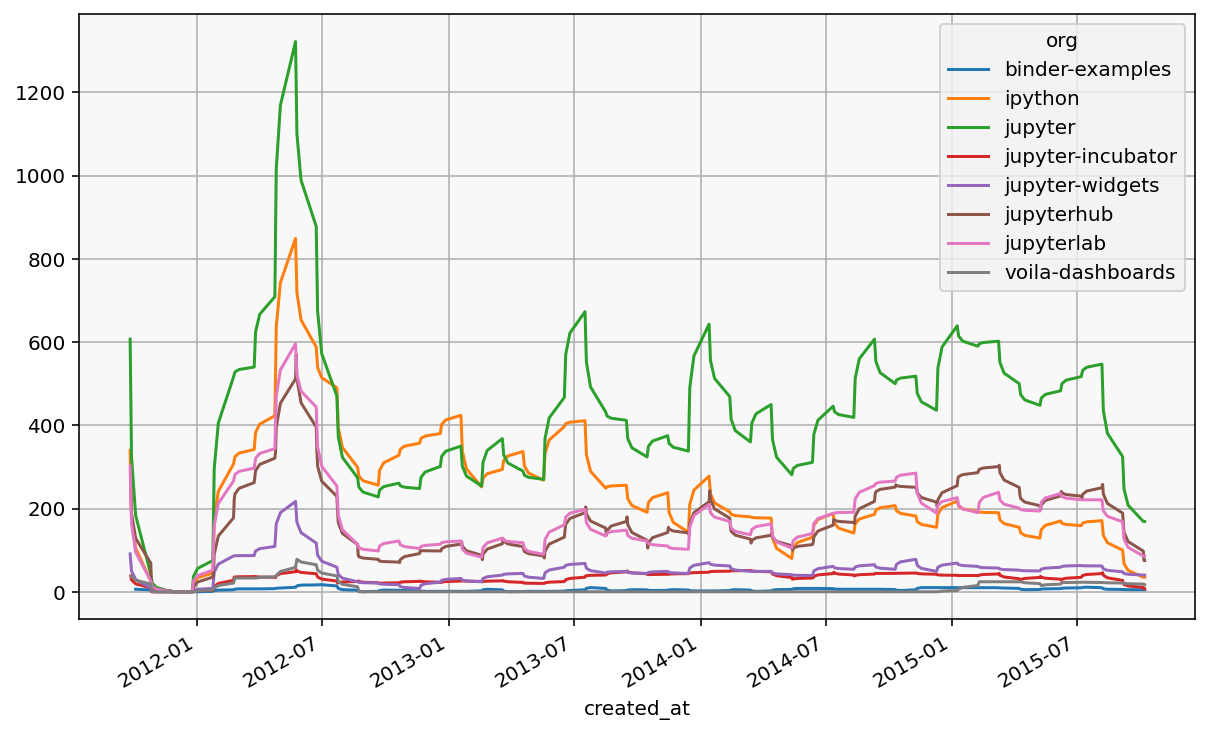

In [83]:
grouped_unique.unstack(level=0).interpolate(method="linear").plot()

In [96]:
df.actor_id.value_counts()

151929      42428
2096628     25858
335567      25691
327925      25220
192614      22082
            ...  
8641479         1
6326957         1
5333648         1
8514177         1
17461326        1
Name: actor_id, Length: 22260, dtype: Int64

In [134]:
bins = list(chain(range(10), np.logspace(1, 4, 100)))
counts, _ = np.histogram(df.actor_id.value_counts(), bins=bins)
counts[:5]

array([    0, 10043,  3709,  2407,  1445])

In [135]:
bins

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10.0,
 10.722672220103231,
 11.497569953977356,
 12.32846739442066,
 13.219411484660288,
 14.174741629268055,
 15.199110829529339,
 16.297508346206442,
 17.47528400007684,
 18.73817422860384,
 20.09233002565047,
 21.544346900318846,
 23.101297000831604,
 24.770763559917114,
 26.560877829466868,
 28.48035868435802,
 30.538555088334157,
 32.74549162877728,
 35.11191734215131,
 37.64935806792467,
 40.37017258596554,
 43.28761281083057,
 46.4158883361278,
 49.770235643321115,
 53.3669923120631,
 57.22367659350217,
 61.35907273413173,
 65.79332246575683,
 70.54802310718645,
 75.64633275546291,
 81.11308307896873,
 86.97490026177834,
 93.26033468832199,
 100.0,
 107.22672220103232,
 114.97569953977356,
 123.28467394420659,
 132.19411484660287,
 141.74741629268047,
 151.99110829529332,
 162.97508346206433,
 174.7528400007683,
 187.3817422860383,
 200.92330025650458,
 215.44346900318845,
 231.01297000831605,
 247.70763559917114,
 265.6087782946687,
 284

437681

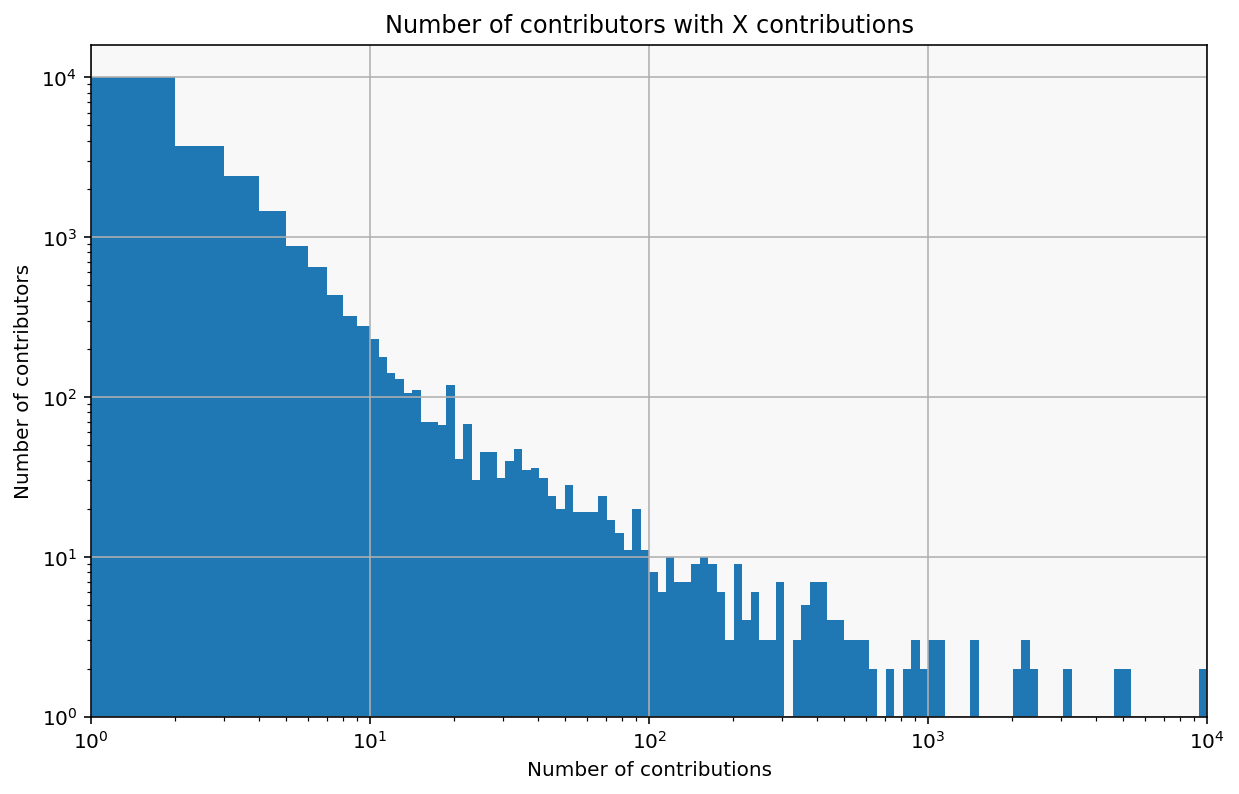

In [143]:
from itertools import chain

fig, ax = plt.subplots()
df.actor_id.value_counts().plot(
    kind="hist",
    bins=bins,
    ax=ax,
    cumulative=0,
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Number of contributors")
ax.set_xlabel("Number of contributions")
ax.set_title("Number of contributors with X contributions")
ax.set_xlim(1, 10000)
ax.set_ylim(1, None)
len(df)

437681

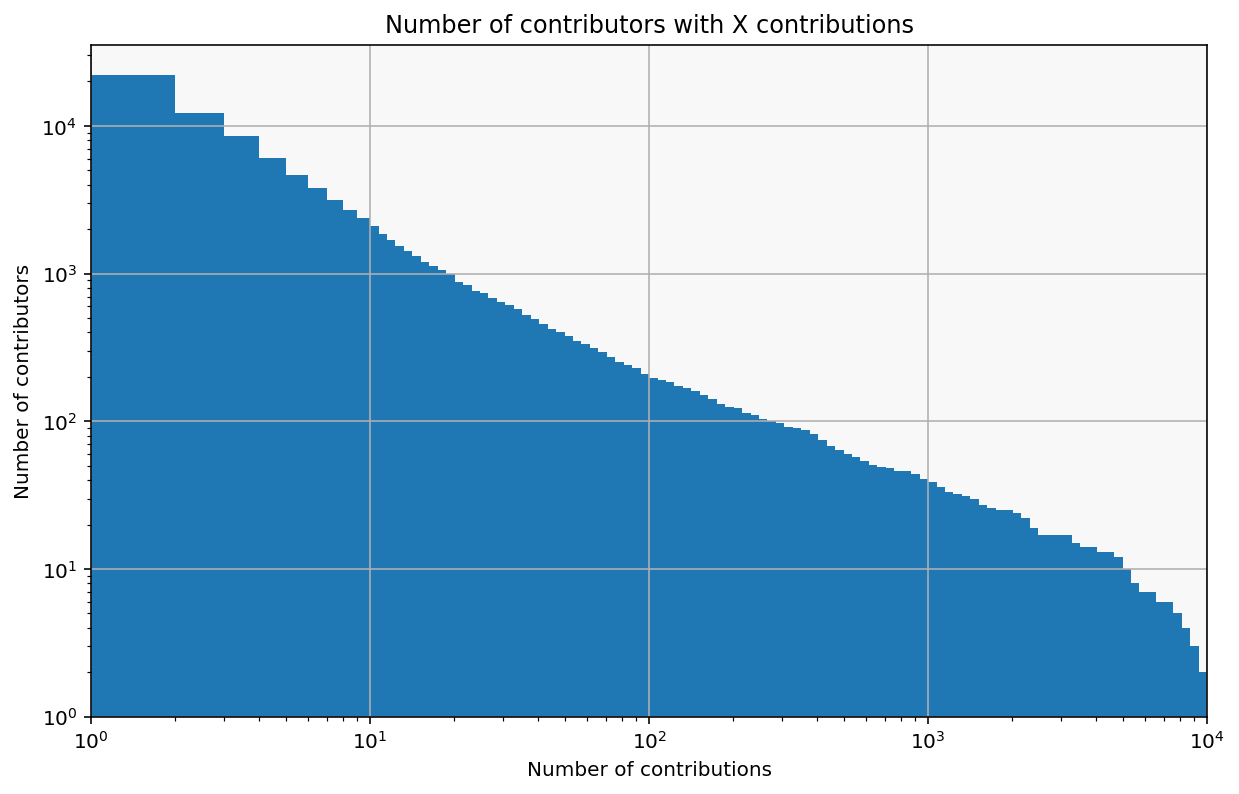

In [153]:
from itertools import chain

fig, ax = plt.subplots()
df.actor_id.value_counts().plot(
    kind="hist",
    bins=bins,
    ax=ax,
    cumulative=-1,
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Number of contributors")
ax.set_xlabel("Number of contributions")
ax.set_title("Number of contributors with X contributions")
ax.set_xlim(1, 10000)
ax.set_ylim(1, None)
len(df)

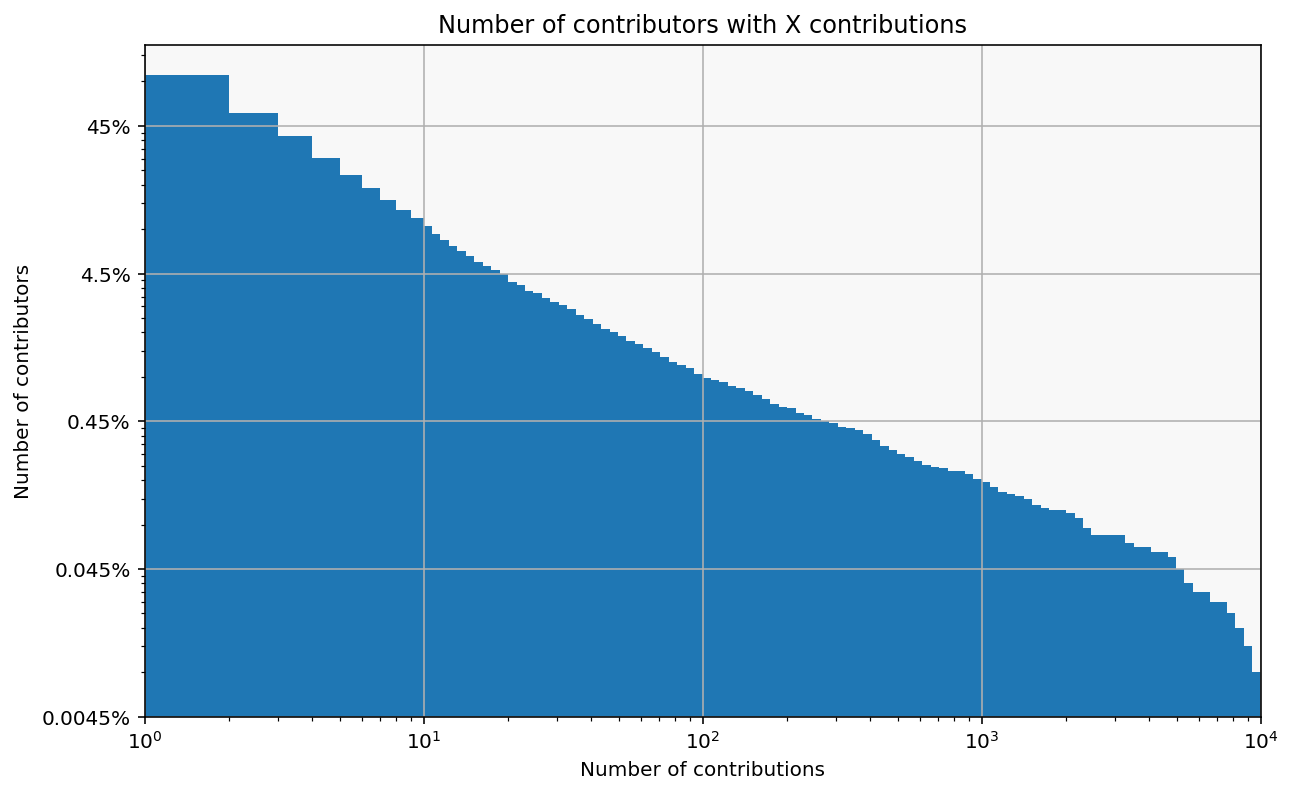

In [157]:
from matplotlib import ticker as tick

def adjust_y_axis(x, pos):
    return f"{100 * x / (len(df.actor_id.unique())):.2g}%"

ax.yaxis.set_major_formatter(tick.FuncFormatter(adjust_y_axis))
display(ax.figure)